# Analysis of environmental data
In this notebook, we will analyze the oceanographic data collected during the Spring Campaign of 2023. The data was collected using a CTD (Conductivity, Temperature, Depth) sensor and the ships underway system. The CTD sensor was deployed every hour at 4 different locations in the Southern North Sea. We'll start with importing the data into this notebook for analysis.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import UnivariateSpline
from matplotlib.dates import HourLocator, DateFormatter
import matplotlib.cm as cm
from matplotlib import colors as mcolors
import sqlite3
from scipy.stats import zscore

## CTD Data

In [ ]:
ctd_data = pd.read_csv('../data/raw/environmental_data.csv', sep=';', index_col=0)
# Make sure the index is a DateTimeIndex type to manipulate dates efficiently
ctd_data.index = pd.to_datetime(ctd_data.index)

# Only include data from stations 51 and 130
ctd_data = ctd_data[ctd_data['StationPrefix'].isin(['51', '130'])]

# It looks like the time is off by two hours (it is in UST), so we'll add a column called 'LocalTime' that is the time in local time
ctd_data['LocalTime'] = ctd_data.index + pd.Timedelta(hours=2)

In [ ]:
ctd_data['Day'].unique()

array([18, 19, 20, 21])

Now, let's add time of high and low tides. We downloaded tidal predictions from the [Flanders Maritime Agency](https://www.agentschapmdk.be/nl/publicaties#getijgegevens-2023), and used the tables for Vlissingen (Station 51) and Ostend (Station 130). In Vlissingen we sampled from 18/04/2023 13:00 to 19/04/2023 09:00. In Ostend we sampled from 20/4/2023 10:00 to 21/4/2023 10:00. Here's the values:

| Location | Date | high tide | low tide | station |
| :-------: | :--------: | :---: | :----------: | :---: |
| Vlissingen | 18/04/2023 | 13:52 | 20:12 | 51 |
| Vlissingen | 19/04/2023 | 02:06 | 08:40 | 51 |
| Ostend | 20/04/2023 | 01:45 | 08:33 | 130 |
| Ostend | 20/04/2023 | 14:12 | 20:50 | 130 |
| Ostend | 21/04/2023 | 02:26 | 09:14 | 130 |

**Note:** These times are in local time, UTC+2. For the analysis, we will convert the times to UTC.

In [ ]:
# Create a tides dataframe
tides_df = pd.DataFrame({
    'Location': ['Vlissingen', 'Vlissingen', 'Ostend', 'Ostend'],
    'Datetime_high_tide': pd.to_datetime(['18/04/2023 11:52', '19/04/2023 00:06', 
                                          '20/04/2023 13:12', '21/04/2023 00:26']),
    'Datetime_low_tide': pd.to_datetime(['18/04/2023 18:12', '19/04/2023 06:40', 
                                         '20/04/2023 18:50', '21/04/2023 07:14']),
    'Station': [51, 51, 130, 130]
})

/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_32528/3353676922.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  'Datetime_high_tide': pd.to_datetime(['18/04/2023 11:52', '19/04/2023 00:06',
/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_32528/3353676922.py:6: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  'Datetime_low_tide': pd.to_datetime(['18/04/2023 18:12', '19/04/2023 06:40',


In [ ]:
def plot_environmental_variable(ctd_data, tides_df, variable, y_limits, output_dir):
    """
    Plot the specified environmental variable over time, colored per station.
    It will also add vertical lines for high and low tides, and shade the period between them.

    Parameters:
    ctd_data (DataFrame): The CTD data containing the environmental variables.
    tides_df (DataFrame): The tides data containing high and low tide times.
    variable (str): The name of the environmental variable to plot.
    y_limits (tuple): The y-axis limits for the plot.
    output_dir (str): The directory where the plot files will be saved.
    """

    # Initiate the plot
    fig, ax = plt.subplots(figsize=(8, 4))

    # Creating the lineplot
    sns.lineplot(x=ctd_data.index, y=variable,
                 hue="StationPrefix",
                 style="StationPrefix",
                 markers=True,
                 dashes=False,
                 data=ctd_data, ax=ax)

    # Setting the title with the parameter being plotted
    ax.set_title(f'{variable} Over Time')

    # Set y axis limits
    ax.set_ylim(y_limits)

    # Formatting the x-axis to show day and month
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))

    # Showing time every 4 hours
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 4)))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))

    # Rotating and showing the x-axis labels
    ax.tick_params(axis='x', rotation=45)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)

    # Showing a grid
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Add vertical lines and shaded regions for high and low tides
    for index, row in tides_df.iterrows():
        if str(row['Station']) in ctd_data['StationPrefix'].unique():
            if ctd_data.index.min() <= row['Datetime_high_tide'] <= ctd_data.index.max():
                ax.axvline(row['Datetime_high_tide'], color='#FB5656', linestyle='-', linewidth=1)
                high_tide_time = row['Datetime_high_tide']
            if ctd_data.index.min() <= row['Datetime_low_tide'] <= ctd_data.index.max():
                ax.axvline(row['Datetime_low_tide'], color='#89BCD6', linestyle='-', linewidth=1)
                low_tide_time = row['Datetime_low_tide']
                # Add grey background for the period between high and low tides
                if 'high_tide_time' in locals() and high_tide_time < low_tide_time:
                    ax.axvspan(high_tide_time, low_tide_time, color='lightgrey', alpha=0.3)
                    del high_tide_time

    # Saving the plot as a .svg and .png file
    plt.savefig(f'{output_dir}/{variable}.svg', format='svg')
    plt.savefig(f'{output_dir}/{variable}.png', format='png')
    # Display the plot
    plt.show()

def plot_environmental_variable_per_station(ctd_data, tides_df, variable, y_limits, output_dir):
    """
    Plot the specified environmental variable over time, per station.
    It will also add vertical lines for high and low tides, and shade the period between them.

    Parameters:
    ctd_data (DataFrame): The CTD data containing the environmental variables.
    tides_df (DataFrame): The tides data containing high and low tide times.
    variable (str): The name of the environmental variable to plot.
    y_limits (tuple): The y-axis limits for the plot.
    output_dir (str): The directory where the plot files will be saved.
    """
    
    # List of unique station prefixes
    stations = ctd_data['Station'].str.split('_').str[0].unique()

    # Loop over each station to create individual plots
    for station in stations:
        station_data = ctd_data[ctd_data['Station'].str.startswith(station)]
        station_tides = tides_df[tides_df['Station'] == int(station)]
        
        # Plot the average environmental variable over time for the current station
        fig, ax = plt.subplots(figsize=(3, 2))

        # Creating the lineplot
        sns.lineplot(x=station_data.index, y=variable,
                     hue="StationPrefix",
                     style="StationPrefix",
                     markers=True,
                     dashes=False,
                     data=station_data, ax=ax)

        # Remove the title and x axis title
        ax.set_title(None)
        ax.set_xlabel(None)

        # Set y axis limits
        ax.set_ylim(y_limits)

        # Formatting the x-axis to show day and month
        ax.xaxis.set_major_locator(mdates.DayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))

        # Showing time every 4 hours
        ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 4)))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))

        # Rotating and showing the x-axis labels
        ax.tick_params(axis='x', rotation=45)
        plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)

        # Showing a grid
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)

        # Saving the plot as .svg and .png files with station prefix and variable name in the filename
        plt.savefig(f'{output_dir}/{variable}_{station}.svg', format='svg')
        plt.savefig(f'{output_dir}/{variable}_{station}.png', format='png')
        # Display the plot
        plt.show()

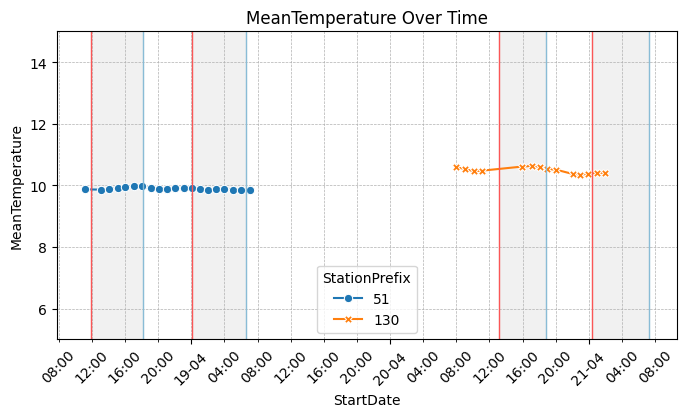

In [ ]:
plot_environmental_variable(ctd_data, tides_df, 'MeanTemperature', (5, 15), '../figures/environmental')

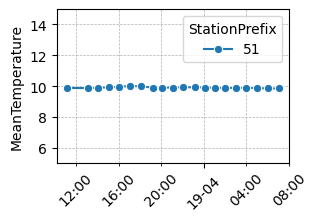

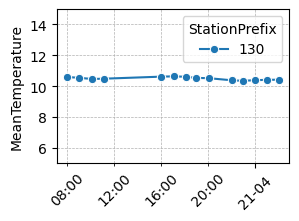

In [ ]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'MeanTemperature', (5, 15), '../figures/environmental')

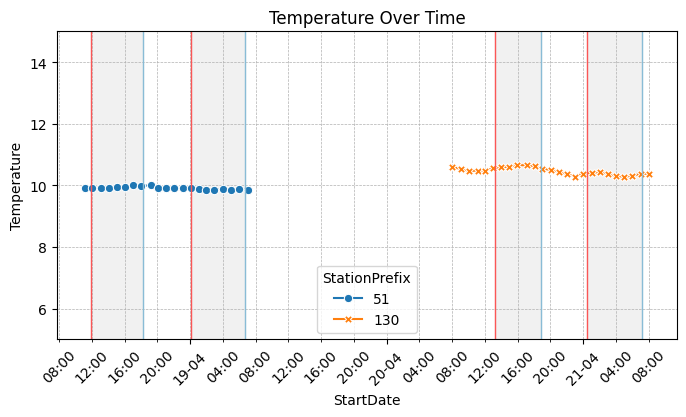

In [ ]:
plot_environmental_variable(ctd_data, tides_df, 'Temperature', (5, 15), '../figures/environmental')

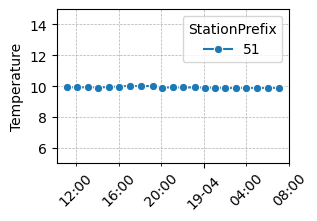

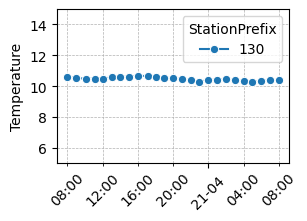

In [ ]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'Temperature', (5, 15), '../figures/environmental')

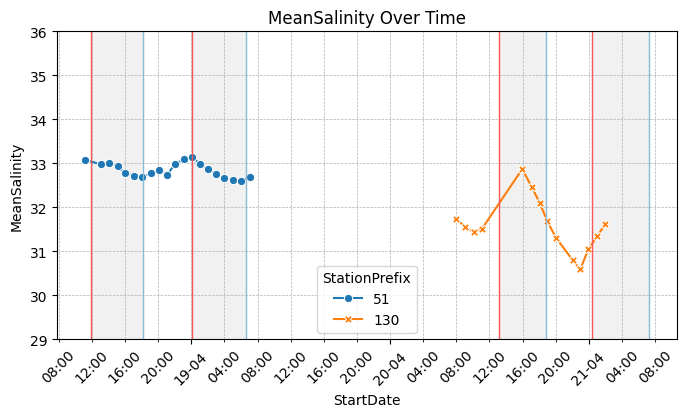

In [ ]:
plot_environmental_variable(ctd_data, tides_df, 'MeanSalinity', (29, 36), '../figures/environmental')

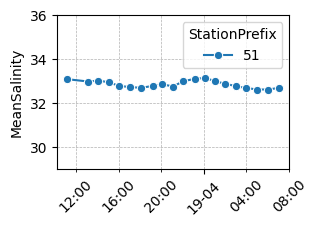

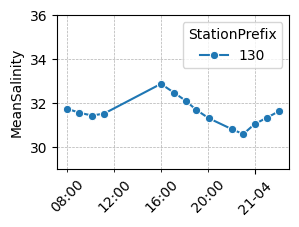

In [ ]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'MeanSalinity', (29, 36), '../figures/environmental')

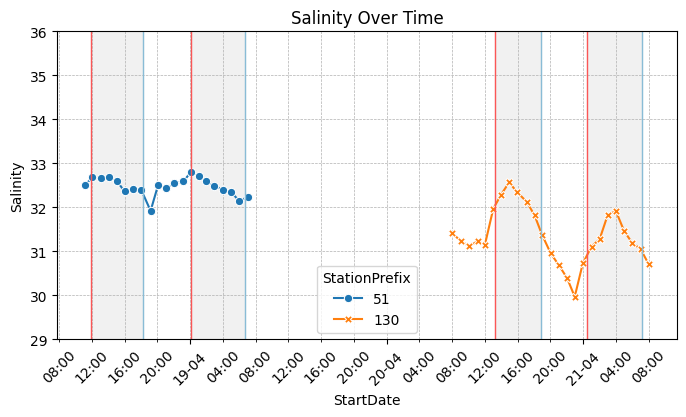

In [ ]:
plot_environmental_variable(ctd_data, tides_df, 'Salinity', (29, 36), '../figures/environmental')

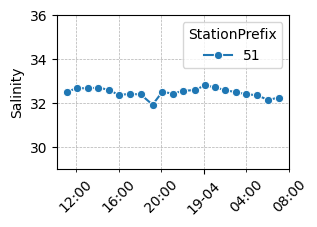

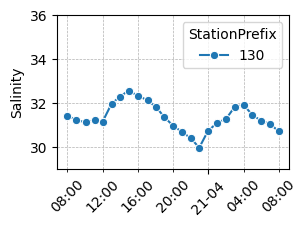

In [ ]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'Salinity', (29, 36), '../figures/environmental')

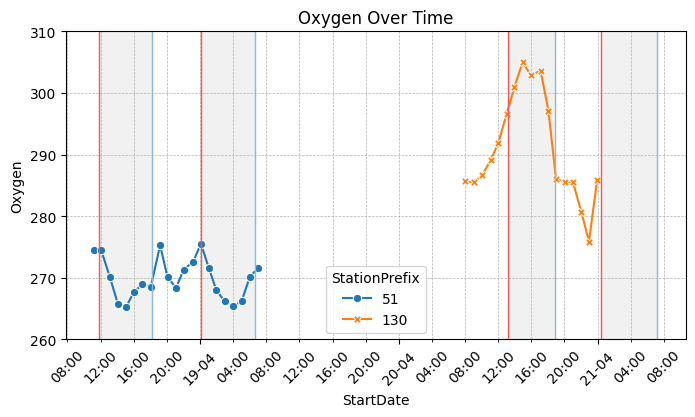

In [ ]:
plot_environmental_variable(ctd_data, tides_df, 'Oxygen', (260, 310), '../figures/environmental')

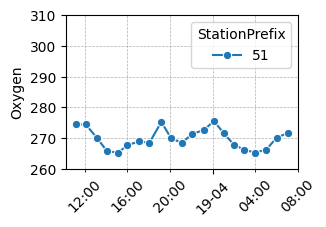

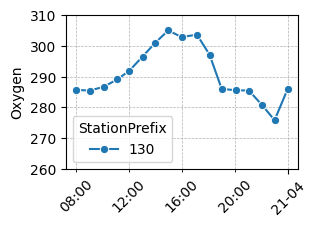

In [ ]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'Oxygen', (260, 310), '../figures/environmental')

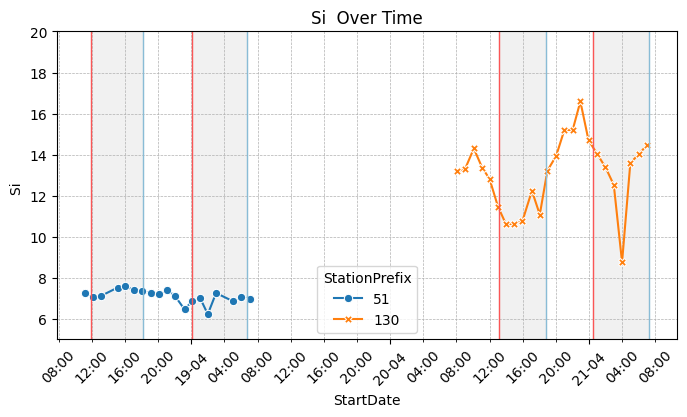

In [ ]:
plot_environmental_variable(ctd_data, tides_df, 'Si ', (5, 20), '../figures/environmental')

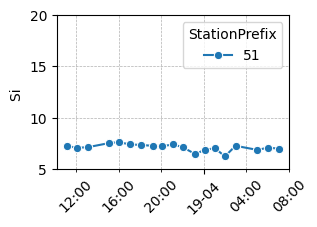

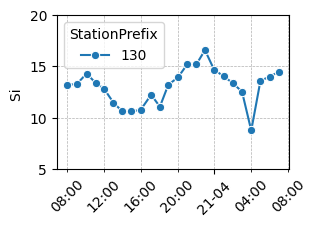

In [ ]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'Si ', (5, 20), '../figures/environmental')

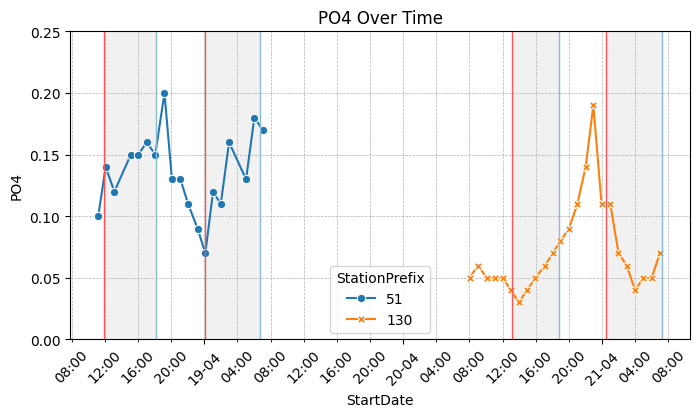

In [ ]:
plot_environmental_variable(ctd_data, tides_df, 'PO4', (0, 0.25), '../figures/environmental')

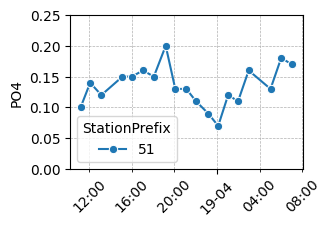

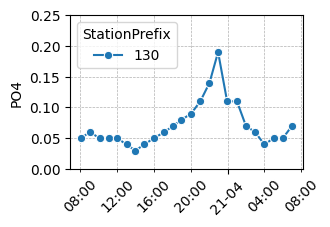

In [ ]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'PO4', (0, 0.25), '../figures/environmental')

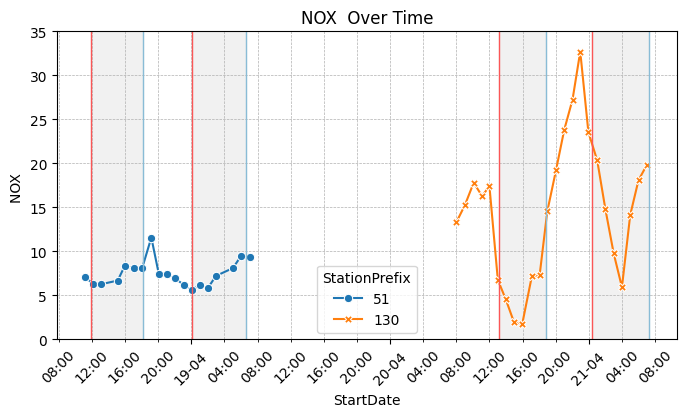

In [ ]:
plot_environmental_variable(ctd_data, tides_df, 'NOX ', (0, 35), '../figures/environmental')

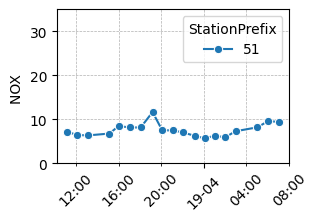

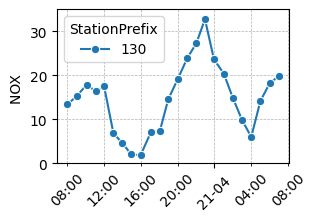

In [ ]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'NOX ', (0, 35), '../figures/environmental')

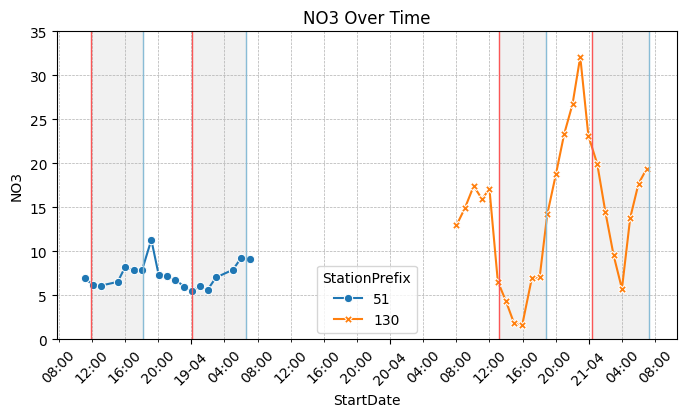

In [ ]:
plot_environmental_variable(ctd_data, tides_df, 'NO3', (0, 35), '../figures/environmental')

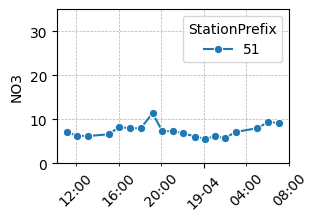

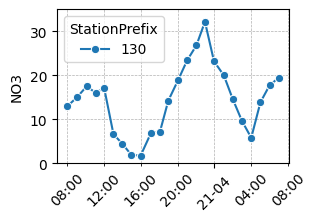

In [ ]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'NO3', (0, 35), '../figures/environmental')

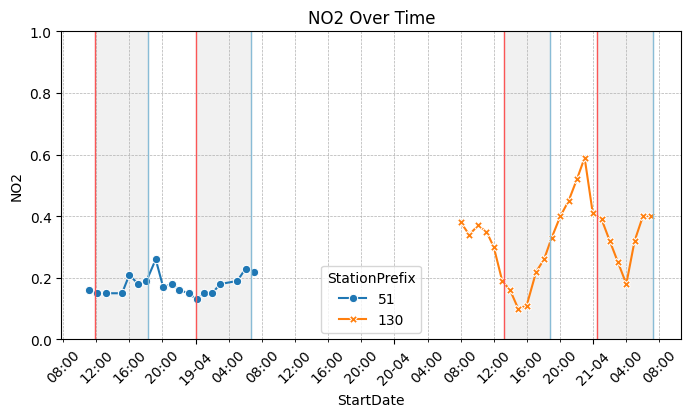

In [ ]:
plot_environmental_variable(ctd_data, tides_df, 'NO2', (0, 1), '../figures/environmental')

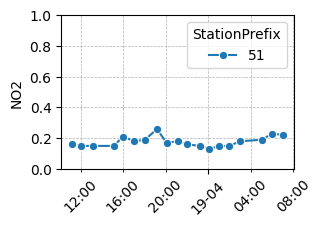

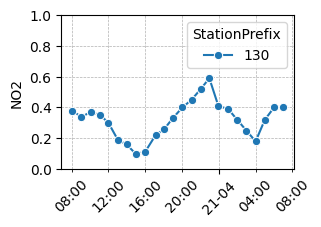

In [ ]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'NO2', (0, 1), '../figures/environmental')

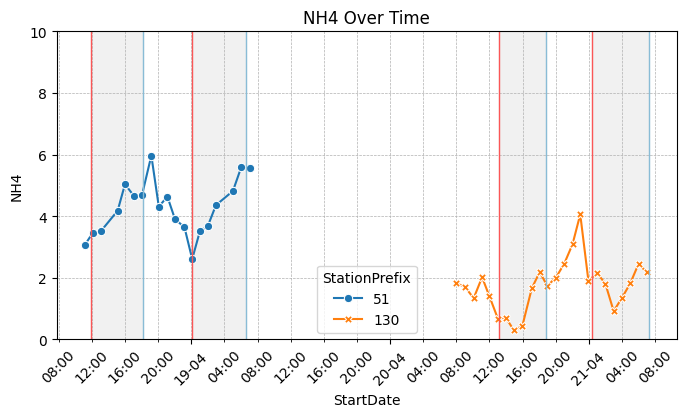

In [ ]:
plot_environmental_variable(ctd_data, tides_df, 'NH4', (0, 10), '../figures/environmental')

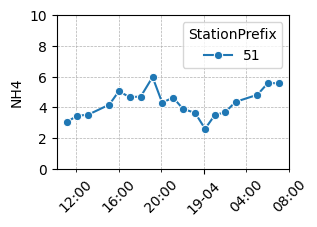

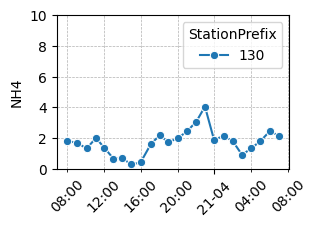

In [ ]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'NH4', (0, 10), '../figures/environmental')

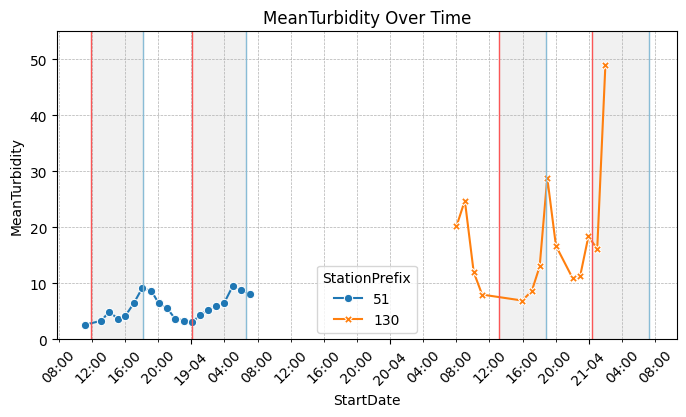

In [ ]:
plot_environmental_variable(ctd_data, tides_df, 'MeanTurbidity', (0, 55), '../figures/environmental')

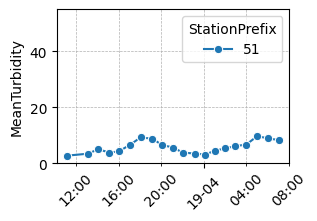

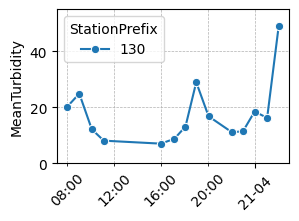

In [ ]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'MeanTurbidity', (0, 55), '../figures/environmental')

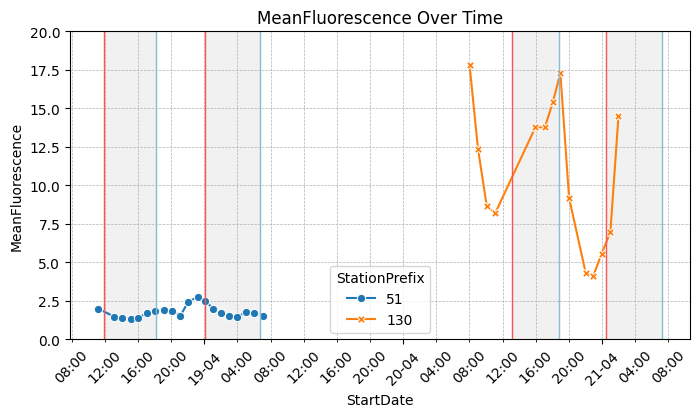

In [ ]:
plot_environmental_variable(ctd_data, tides_df, 'MeanFluorescence', (0, 20), '../figures/environmental')

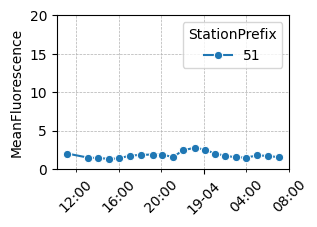

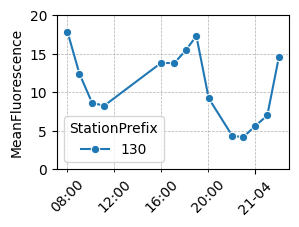

In [ ]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'MeanFluorescence', (0, 20), '../figures/environmental')

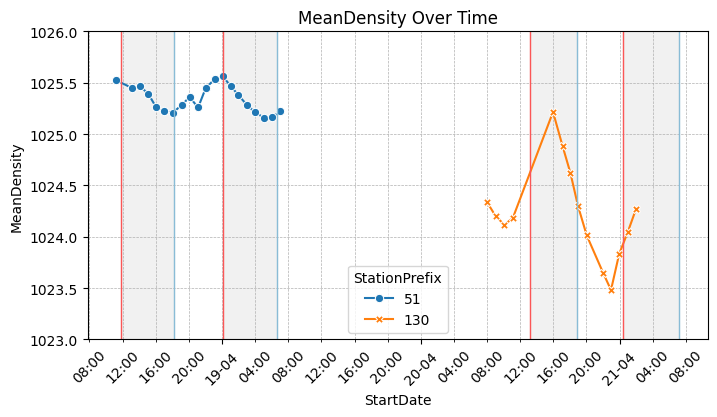

In [ ]:
plot_environmental_variable(ctd_data, tides_df, 'MeanDensity', (1023, 1026), '../figures/environmental')

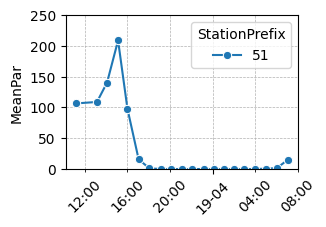

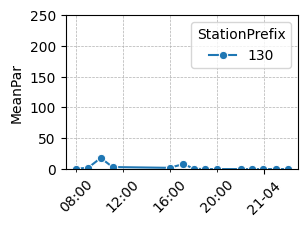

In [ ]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'MeanPar', (0, 250), '../figures/environmental')

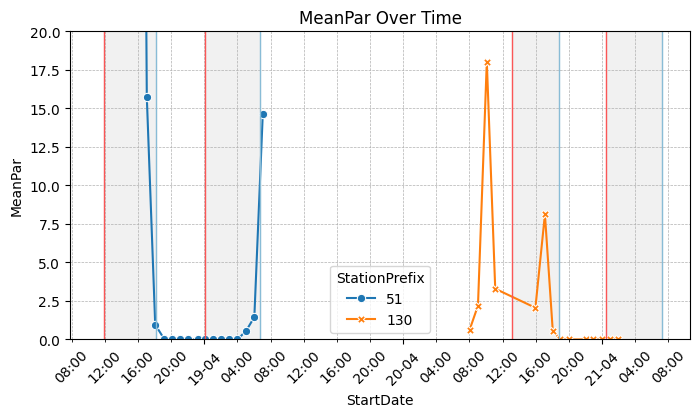

In [ ]:
plot_environmental_variable(ctd_data, tides_df, 'MeanPar', (0, 20), '../figures/environmental')

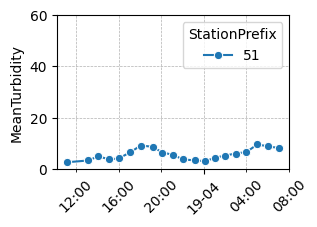

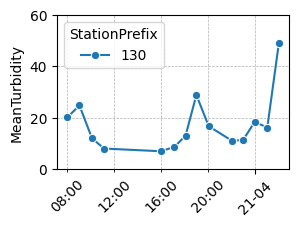

In [ ]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'MeanTurbidity', (0, 60), '../figures/environmental')

In [ ]:
ctd_data.columns

Index(['MeanConductivity', 'MeanDensity', 'MeanFluorescence', 'MeanPar',
       'MeanPressure', 'MeanSalinity', 'MeanSoundVelocity', 'MeanTemperature',
       'MeanTurbidity', 'NH4', 'NO2', 'NO3', 'NOX ', 'PO4', 'Si ', 'TEP',
       'StationPrefix', 'StationSuffix', 'StartLat', 'StartLong',
       'Temperature', 'Salinity', 'Conductivity', 'Depth', 'Oxygen',
       'OxygenRaw', 'Station', 'Month', 'Year', 'Day', 'Hour', 'Minute',
       'LocalTime'],
      dtype='object')

In [ ]:
variable = 'Salinity'
# Print mean variance and standard deviation for each station for this variable
print(ctd_data.groupby('StationPrefix')[variable].agg(['mean', 'var', 'std']))

# Print the max value and the time of maximum value for this variable per station
print(ctd_data.groupby('StationPrefix')[variable].agg(['max', 'idxmax']))

# Print min value and the time of minimum value for this variable per station
print(ctd_data.groupby('StationPrefix')[variable].agg(['min', 'idxmin']))

                    mean       var       std
StationPrefix                               
130            31.357680  0.400921  0.633184
51             32.478286  0.042969  0.207289
                  max              idxmax
StationPrefix                            
130            32.569 2023-04-20 14:57:00
51             32.807 2023-04-19 00:07:00
                  min              idxmin
StationPrefix                            
130            29.972 2023-04-20 22:58:00
51             31.923 2023-04-18 19:11:00


## Create environmental dataset for analysis
Here we'll combine the LW data, and buoy data, with sampling metadata in order to generate an easy dataset to work with in subsequent analyses. We'll pull in additional data using [bpnsdata](https://github.com/lifewatch/bpnsdata) if available.

In [ ]:
# Clone the github package to the local machine and add it to the path
import sys
import os
sys.path.append('../../bpnsdata')
import bpnsdata
import geopandas as gpd
from suntime import Sun

In [ ]:
os.environ['username_banken'] = 'michiel.perneel@vliz.be'
os.environ['password_banken'] = 'zYjjoj-kumtav-4himqe'

In [ ]:
# Add date column to the ctd_data
ctd_data['Date'] = ctd_data.index

# Add date column to the ctd_data
ctd_data['Date'] = ctd_data.index

# Run the sea_manager over every row in the dataframe for the ERDDAP data
env_vars = ['shipping', 'time', 'wrakken_bank', 'habitat_suitability',
            'seabed_habitat', 'sea_surface']

sea_manager = bpnsdata.SeaDataManager(env_vars=env_vars)

results = []  # List to hold the result from each row

for index, row in ctd_data.iterrows():
    try:
        # Convert the single row DataFrame to a GeoDataFrame
        single_row_gdf = gpd.GeoDataFrame([row], geometry=gpd.points_from_xy([row['StartLong']], [row['StartLat']]), crs='EPSG:4269')
        
        # Calculate day length
        sun = Sun(row['StartLat'], row['StartLong'])
        sunrise = sun.get_sunrise_time(row['Date'])
        sunset = sun.get_sunset_time(row['Date'])
        day_length = sunset - sunrise  # This will give you a timedelta object
        
        # Process the row
        result = sea_manager(single_row_gdf, datetime_column='Date')
        
        # Add day length
        result['day_length'] = day_length.total_seconds() / 3600  # Day length in hours
        
        # Append the result
        results.append(result)
    except Exception as e:
        print(f"Error processing row {index}: {e}")

# Concatenate all results into a single DataFrame
results_df = pd.concat(results, ignore_index=True)

In [ ]:
# Create a dictionary to map old column names to new ones
column_rename_map = {
    'MeanFluorescence': 'Fluorescence',
    'NH4': 'NH4',
    'NO2': 'NO2',
    'NO3': 'NO3',
    'NOX ': 'NOX',  # Ensure there is no extra space after 'NOX'
    'PO4': 'PO4',
    'Si ': 'Si',    # Ensure there is no extra space after 'Si'
    'TEP': 'TEP',
    'StationPrefix': 'StationPrefix',
    'StationSuffix': 'StationSuffix',
    'StartLat': 'Latitude',
    'StartLong': 'Longitude',
    'Temperature': 'Temperature',
    'Salinity': 'Salinity',
    'Conductivity': 'Conductivity',
    'Depth': 'Depth',
    'Oxygen': 'Oxygen',
    'Station': 'Station',
    'Date': 'Date',
    'LocalTime': 'LocalTime',
    'day_moment': 'day_moment',
    'sea_surface_height_above_sea_level': 'sea_surface_height_above_sea_level',
    'surface_baroclinic_sea_water_velocity': 'surface_baroclinic_sea_water_velocity',
    'day_length': 'day_length'
}

# Select the columns of interest and rename them in one step
results_df = results_df[list(column_rename_map.keys())].rename(columns=column_rename_map)

# Reorder columns to put 'Station' first
ordered_columns = ['Station', 'StationPrefix', 'StationSuffix', 'Latitude', 'Longitude', 'Date', 'day_moment', 'day_length',
                   'Temperature', 'Salinity', 'Conductivity', 'Depth', 'Oxygen', 'Fluorescence', 'NH4', 'NO2', 'NO3', 'NOX', 
                   'PO4', 'Si', 'TEP', 'sea_surface_height_above_sea_level', 'surface_baroclinic_sea_water_velocity']

results_df = results_df[ordered_columns]

In [ ]:
results_df.head()

Station StationPrefix  StationSuffix   Latitude  Longitude  \
0    51_1            51              1  51.531661   3.182804   
1    51_2            51              2  51.533392   3.184085   
2    51_3            51              3  51.532763   3.185113   
3    51_4            51              4  51.533244   3.184346   
4    51_5            51              5  51.533104   3.183575   

                 Date day_moment  day_length  Temperature  Salinity  ...  \
0 2023-04-18 11:11:00        Day   14.033333       9.9259    32.513  ...   
1 2023-04-18 12:05:00        Day   14.033333       9.9105    32.683  ...   
2 2023-04-18 13:08:00        Day   14.033333       9.9231    32.661  ...   
3 2023-04-18 14:05:00        Day   14.033333       9.9013    32.703  ...   
4 2023-04-18 15:07:00        Day   14.033333       9.9336    32.590  ...   

   Fluorescence   NH4   NO2   NO3   NOX   PO4    Si         TEP  \
0      2.001848  3.08  0.16  6.96  7.12  0.10  7.24   65.846667   
1           NaN  3.45  0.15  6.19  6.34  0.14  7.06  167.438667   
2      1.472718  3.53  0.15  6.13  6.28  0.12  7.13  210.709333   
3      1.423711   NaN   NaN   NaN   NaN   NaN   NaN  255.861333   
4      1.315579  4.18  0.15  6.54  6.69  0.15  7.53  223.878667   

   sea_surface_height_above_sea_level  surface_baroclinic_sea_water_velocity  
0                            1.817039                               0.737314  
1                            2.129479                               0.933577  
2                            1.852063                               0.844863  
3                            1.210772                               0.645538  
4                            0.336479                               0.489504  

[5 rows x 23 columns]

In [ ]:
# Save the results to a CSV file
results_df.to_csv('../data/samples_env.csv', index=False)

### Chlorophyll-a
Here, we'll add the chlorophyll-a data from the underway system. 

In [ ]:
chlorophyll = pd.read_csv('../data/raw/202304_Chl-a_sensordata.csv')
# Timestamp as datetime
## First, remove the .000 from the timestamp
chlorophyll['timestamp'] = chlorophyll['timestamp'].str.replace('.000', '', regex=False)
chlorophyll['timestamp'] = pd.to_datetime(chlorophyll['timestamp'], format='%Y-%m-%d %H:%M:%S')
# Drop the counts column
chlorophyll.drop(columns=['counts'], inplace=True)
# Rename the eng column to 'Chlorophyll_a'
chlorophyll.rename(columns={'eng': 'Chlorophyll_a'}, inplace=True)

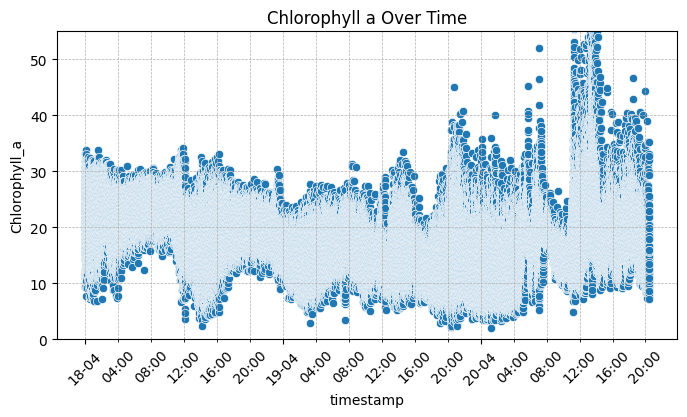

In [ ]:
# Now plot the chlorophyll a data
## Select the chlorophyll a data within the date range of interest
chlorophyll_data = chlorophyll[(chlorophyll['timestamp'] >= '2023-04-18') & (chlorophyll['timestamp'] <= '2023-04-21')]
## Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))
## Create a lineplot
sns.scatterplot(x=chlorophyll_data['timestamp'], y=chlorophyll_data['Chlorophyll_a'], ax=ax)
## Set the title
ax.set_title('Chlorophyll a Over Time')
## Set the y axis limits
ax.set_ylim(0, 55)
## Formatting the x-axis to show day and month
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
## Showing time every 4 hours
ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 4)))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
## Rotating and showing the x-axis labels
ax.tick_params(axis='x', rotation=45)
plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)
## Showing a grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.show()

In [ ]:
# Connect to the SQLite database
conn = sqlite3.connect('../data/raw/chla.sqlite')

# Check available tables
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)

   name
0  data


In [ ]:
# Inspect the corrected data
corrected = pd.read_sql_query("SELECT * FROM data LIMIT 5;", conn)
print(corrected.head())

                 timestamp    eng  counts
0  2023-04-17 08:19:21.000   2.01     333
1  2023-04-17 08:19:22.000   5.65     812
2  2023-04-17 08:19:23.000  17.40    2357
3  2023-04-17 08:19:24.000  21.49    2895
4  2023-04-17 08:19:25.000  16.70    2266


In [ ]:
# Load corrected data from the SQLite 'data' table
corrected_chla = pd.read_sql_query("SELECT * FROM data;", conn)

# Remove '.000' and convert to datetime
corrected_chla['timestamp'] = corrected_chla['timestamp'].str.replace('.000', '', regex=False)
corrected_chla['timestamp'] = pd.to_datetime(corrected_chla['timestamp'], format='%Y-%m-%d %H:%M:%S')

# Rename the 'eng' column to match your expected Chlorophyll column
corrected_chla.rename(columns={'eng': 'Chlorophyll_a'}, inplace=True)

# Drop counts column (if no longer needed)
corrected_chla.drop(columns=['counts'], inplace=True)

In [ ]:
# Define a function that performs smoothing and plotting given a resampling interval
def smooth_and_plot(df, start_date, end_date, resample_interval='15T', smoothing_window_sec=60):
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    from statsmodels.nonparametric.smoothers_lowess import lowess
    from scipy.interpolate import UnivariateSpline
    import numpy as np

    # Filter date range
    df_range = df[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)].copy()

    # Resample if specified
    df_resampled = df_range.set_index('timestamp').resample(resample_interval).median().reset_index()

    # Convert timestamps to seconds (from ns)
    df_resampled['timestamp_sec'] = df_resampled['timestamp'].astype('int64') / 1e9

    # Ensure the data is sorted
    df_resampled = df_resampled.sort_values('timestamp')

    # Prepare X and y
    X = df_resampled['timestamp_sec'].values
    y = df_resampled['Chlorophyll_a'].values

    # ---- LOESS Smoothing ----
    duration = X.max() - X.min()
    frac_val = smoothing_window_sec / duration
    loess_result = lowess(endog=y, exog=X, frac=frac_val, delta=smoothing_window_sec, return_sorted=False)
    df_resampled['loess_pred'] = loess_result

    # ---- Spline Smoothing ----
    s_value = smoothing_window_sec * np.var(y)
    spline = UnivariateSpline(X, y, s=s_value)
    df_resampled['spline_pred'] = spline(X)

    # ---- Plot ----
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.scatter(df_resampled['timestamp'], df_resampled['Chlorophyll_a'], s=20, alpha=0.5, label='Original (resampled)')
    ax.plot(df_resampled['timestamp'], df_resampled['loess_pred'], color='red', label='LOESS')
    ax.plot(df_resampled['timestamp'], df_resampled['spline_pred'], color='green', label='Spline')

    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 4)))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
    ax.tick_params(axis='x', rotation=45)

    ax.set_title(f'Chlorophyll a: LOESS vs Spline (resample={resample_interval})')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Chlorophyll a (Chlorophyll_a)')
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_32528/3589032341.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df_range.set_index('timestamp').resample(resample_interval).median().reset_index()


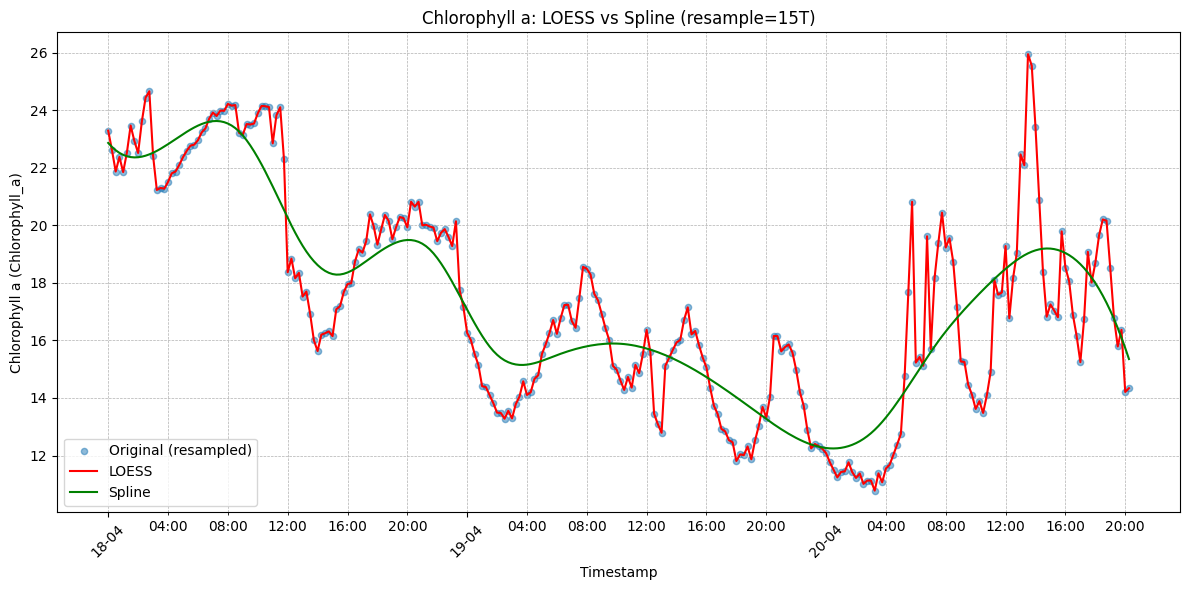

In [ ]:
# Run function with default 15-minute resampling
smooth_and_plot(chlorophyll, start_date='2023-04-18', end_date='2023-04-21', resample_interval='15T')

In [ ]:
def safe_fill_between(ax, df, label=None):
    # Ensure types are correct
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.dropna(subset=['Chl_a_var'])

    # Calculate standard deviation and bounds
    std_dev = np.sqrt(df['Chl_a_var'].values)
    lower = df['Chlorophyll_a'].values - std_dev
    upper = df['Chlorophyll_a'].values + std_dev

    # Plot variance shading
    ax.fill_between(df['timestamp'].values, lower, upper,
                    color='gray', alpha=0.5, label=label)

def smooth_and_plot_with_variance(df, results_df, start_date, end_date,
                                  resample_interval='5T',
                                  spline_sensitivity_factor=15,
                                  station_name=''):

    background_colors = {
        'day': '#ffffb3',
        'civil twilight': '#ffe0a3',
        'nautical twilight': '#ffc870',
        'astronomical twilight': '#ffb347',
        'night': '#d9d9d9'
    }

    df_range = df[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)].copy()
    df_range = df_range.sort_values('timestamp')

    df_stat = df_range.set_index('timestamp').resample(resample_interval).agg({
        'Chlorophyll_a': ['median', 'var']
    }).reset_index()
    df_stat.columns = ['timestamp', 'Chlorophyll_a', 'Chl_a_var']
    df_stat['timestamp_sec'] = df_stat['timestamp'].astype('int64') / 1e9

    # Spline smoothing
    X = df_stat['timestamp_sec'].values
    y = df_stat['Chlorophyll_a'].values
    s_value = spline_sensitivity_factor * np.var(y)
    spline = UnivariateSpline(X, y, s=s_value)
    df_stat['spline_pred'] = spline(X)

    # Z-score transformation
    df_stat['spline_zscore'] = zscore(df_stat['spline_pred'], nan_policy='omit')

    # Interpolation to sample times
    results_subset = results_df[(results_df['Date'] >= pd.to_datetime(start_date)) &
                                (results_df['Date'] <= pd.to_datetime(end_date))].copy()

    results_subset['Chl_a_smoothed'] = np.interp(
        results_subset['Date'].astype('int64') / 1e9,
        df_stat['timestamp_sec'],
        df_stat['spline_pred']
    )
    results_subset['Chl_a_zscore'] = np.interp(
        results_subset['Date'].astype('int64') / 1e9,
        df_stat['timestamp_sec'],
        df_stat['spline_zscore']
    )

    ### -------- Plot 1: Original Chlorophyll a -------- ###
    fig, ax = plt.subplots(figsize=(5, 3))
    for moment, group in results_subset.groupby('day_moment'):
        ax.axvspan(group['Date'].min(), group['Date'].max(),
                   color=background_colors.get(moment.lower(), '#f0f0f0'), alpha=0.7)

    safe_fill_between(ax, df_stat, label='±1 SD (per 5min)')
    ax.scatter(df_stat['timestamp'], df_stat['Chlorophyll_a'], s=10, alpha=0.5, label='Original (resampled)')
    ax.plot(df_stat['timestamp'], df_stat['spline_pred'], color='green', linewidth=1.5, label='Spline-smoothed')

    ax.set(title=f'Station {station_name}', ylabel='Chlorophyll a')
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 4)))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(0, 40)
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.savefig(f'../figures/environmental/chlorophyll_smoothing_{station_name}.png', dpi=1200)
    plt.savefig(f'../figures/environmental/chlorophyll_smoothing_{station_name}.svg', dpi=1200)
    plt.show()

    ### -------- Plot 2: Z-score version -------- ###
    fig, ax = plt.subplots(figsize=(5, 3))
    for moment, group in results_subset.groupby('day_moment'):
        ax.axvspan(group['Date'].min(), group['Date'].max(),
                   color=background_colors.get(moment.lower(), '#f0f0f0'), alpha=0.7)

    ax.plot(df_stat['timestamp'], df_stat['spline_zscore'], color='purple', linewidth=1.5, label='Z-scored spline')
    ax.set(title=f'Station {station_name} (Z-score)', ylabel='Z-score (Chl a)')
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 4)))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
    ax.tick_params(axis='x', rotation=45)
    ax.axhline(0, color='gray', linestyle='--')
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.savefig(f'../figures/environmental/chlorophyll_smoothing_zscore_{station_name}.png', dpi=1200)
    plt.savefig(f'../figures/environmental/chlorophyll_smoothing_zscore_{station_name}.svg', dpi=1200)
    plt.show()

    return df_stat, results_subset

/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_32528/3608067732.py:32: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_stat = df_range.set_index('timestamp').resample(resample_interval).agg({


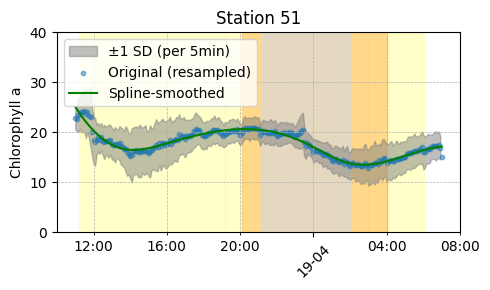

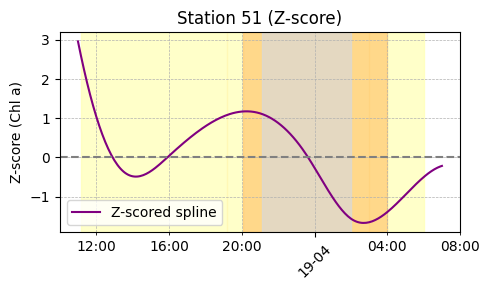

/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_32528/3608067732.py:32: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_stat = df_range.set_index('timestamp').resample(resample_interval).agg({


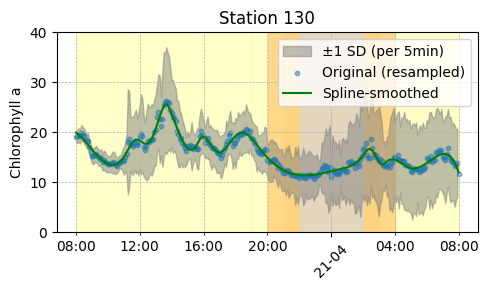

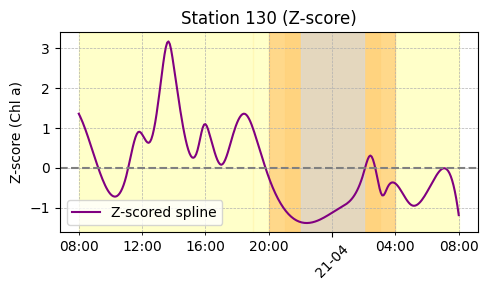

In [ ]:
station_51_resampled, station_51_samples = smooth_and_plot_with_variance(
    corrected_chla, results_df,
    start_date='2023-04-18 11:00',
    end_date='2023-04-19 07:00',
    resample_interval='5T',
    station_name='51'
)

station_130_resampled, station_130_samples = smooth_and_plot_with_variance(
    corrected_chla, results_df,
    start_date='2023-04-20 08:00',
    end_date='2023-04-21 08:00',
    resample_interval='5T',
    station_name='130'
)


In [ ]:
station_130_samples

Station StationPrefix  StationSuffix   Latitude  Longitude  \
21   130_1           130              1  51.216349   2.851257   
22   130_2           130              2  51.216407   2.851156   
23   130_3           130              3  51.216440   2.851073   
24   130_4           130              4  51.217018   2.853022   
25   130_5           130              5  51.217751   2.852111   
26   130_6           130              6  51.217754   2.851928   
27   130_7           130              7  51.217704   2.852383   
28   130_8           130              8  51.216677   2.852190   
29   130_9           130              9  51.216404   2.851225   
30  130_10           130             10  51.216495   2.850992   
31  130_11           130             11  51.216648   2.850879   
32  130_12           130             12  51.216639   2.850865   
33  130_13           130             13  51.216597   2.850890   
34  130_14           130             14  51.216600   2.850907   
35  130_15           130             15  51.216605   2.850903   
36  130_16           130             16  51.216552   2.850975   
37  130_17           130             17  51.218769   2.852678   
38  130_18           130             18  51.217923   2.853985   
39  130_19           130             19  51.218877   2.852741   
40  130_20           130             20  51.218921   2.852949   
41  130_21           130             21  51.218132   2.852240   
42  130_22           130             22  51.218137   2.852084   
43  130_23           130             23  51.218035   2.852047   
44  130_24           130             24  51.217991   2.852068   
45  130_25           130             25  51.217959   2.852102   

                  Date             day_moment  day_length  Temperature  \
21 2023-04-20 08:01:00                    Day   14.133333      10.5994   
22 2023-04-20 09:02:00                    Day   14.133333      10.5378   
23 2023-04-20 10:06:00                    Day   14.133333      10.4671   
24 2023-04-20 11:07:00                    Day   14.133333      10.4846   
25 2023-04-20 12:00:00                    Day   14.133333      10.4787   
26 2023-04-20 13:01:00                    Day   14.133333      10.5643   
27 2023-04-20 13:58:00                    Day   14.133333      10.5962   
28 2023-04-20 14:57:00                    Day   14.133333      10.6031   
29 2023-04-20 15:58:00                    Day   14.133333      10.6638   
30 2023-04-20 17:07:00                    Day   14.133333      10.6523   
31 2023-04-20 18:04:00                    Day   14.133333      10.6196   
32 2023-04-20 18:59:00         Civil twilight   14.133333      10.5362   
33 2023-04-20 20:02:00      Nautical twilight   14.133333      10.5101   
34 2023-04-20 21:02:00  Astronomical twilight   14.133333      10.4449   
35 2023-04-20 22:02:00                  Night   14.133333      10.3731   
36 2023-04-20 22:58:00                  Night   14.133333      10.2875   
37 2023-04-20 23:57:00                  Night   14.133333      10.3815   
38 2023-04-21 01:01:00                  Night   14.200000      10.4159   
39 2023-04-21 02:00:00                  Night   14.200000      10.4284   
40 2023-04-21 03:00:00  Astronomical twilight   14.200000      10.3868   
41 2023-04-21 04:00:00      Nautical twilight   14.200000      10.3065   
42 2023-04-21 05:00:00                    Day   14.200000      10.2812   
43 2023-04-21 06:00:00                    Day   14.200000      10.3155   
44 2023-04-21 07:00:00                    Day   14.200000      10.3710   
45 2023-04-21 08:00:00                    Day   14.200000      10.3828   

    Salinity  ...   NH4   NO2    NO3    NOX   PO4     Si          TEP  \
21    31.418  ...  1.82  0.38  12.96  13.34  0.05  13.20  1286.832000   
22    31.236  ...  1.71  0.34  14.91  15.25  0.06  13.29  1202.172000   
23    31.121  ...  1.34  0.37  17.44  17.81  0.05  14.30  1326.340000   
24    31.234  ...  2.02  0.35  15.94  16.29  0.05  13.36  1083.648000   
25    31.152  ...  1.4

In [ ]:
# Combine the two DataFrames 
combined_samples = pd.concat([station_51_samples, station_130_samples], ignore_index=True)
# Save the combined DataFrame to a CSV file
combined_samples.to_csv('../data/samples_env_chlorophyll.csv', index=False)

### CTD depth profiles
Now, we'll visualize the depth profiles collected with CTD at the two stations.
The goal is to create a plot with depth on the y-axis and temperature on the x-axis, with salinity on the right y-axis. We'll visualize time with color.
CTD Depth data has the following available columns:

- **Station**: Name or code of sampling station or receiver code.
- **CastId**: Unique identifier to specify a single CTD-cast.
- **Depth**: Bottom depth to surface from echosounder 200Hz in m.
- **Status**: An identifier to specify whether a specific measurement was taken in the up-cast, the down-cast, near the bottom, or during the calibration-phase at the surface.
- **Latitude**: Center latitude in decimal degrees, WGS84.
- **Longitude**: Center longitude in decimal degrees, WGS84.
- **Time**: Time in UTC, beginning of sample timeperiod.
- **Obs3+**: Turbidity measured by the CTD (expressed in NTU)
- **AltM**: Altimetry measured by the CTD (expressed in m).
- **Par**: Photosynthetic Active Radiation.
- **FIECO-AFL**: Fluorescence measured by the CTD (expressed in mg/m3).
- **Oxigenvoltage**: Oxygen measured by the CTD (expressed in V).
- **Sbeox0Mg/L**: Oxygen measured by CTD (expressed in mg/L).
- **Sbeox0PS**: Oxygen percentage measured by CTD.
- **PrdM**: Pressure measured by the CTD (expressed in db).
- **Temperature**: Temperature of air or the water body, expressed in degrees Celcius.
- **C0uS/cm**: Conducitivity of the water body, expressed in ms/cm.
- **Salinity**: Salinity of the water body, expressed in PSU.
- **Soundspeed**: The velocity of sound through the water body, expressed in m/s.
- **Density**: Calculated densities of zooplankton expressed in specimens/m³, by using the count, fraction, volumeM or volumeC.
- **DescSpeed**: The speed by which the CTD-carroussel was winched through the water column, expressed in m/s.
- **Flag**: A quality flag associated with a certain measurement.

In [ ]:
ctd_depth = pd.read_csv('../data/raw/CTD_casts.csv')

# If present, remove the 'JN_22' prefix from the STATION column
ctd_depth['STATION'] = ctd_depth['STATION'].str.replace('JN22_', '')

# Split STATION column into Station and cast, only retain the first two columns
ctd_depth[['station', 'cast']] = ctd_depth['STATION'].str.split('_', expand=True)

# Only keep station 51 and 130
ctd_depth = ctd_depth[ctd_depth['station'].isin(['51', '130'])]

# Only consider samples deeper than 1 meters
ctd_depth = ctd_depth[ctd_depth['DEPTH'] > 1]

# Convert the DATE column to a datetime object
ctd_depth['date'] = pd.to_datetime(ctd_depth['sampletime'])

# Add a hour column
ctd_depth['hour'] = ctd_depth['date'].dt.hour

# Re-do the status column as the flags might be incorrect
## First, add a new status column
ctd_depth['status_2'] = 'downcast/soaking'
## For every cast, figure out the maximum depth of the cast and flag every sample that was taken after the deepest point as upcast
for cast in ctd_depth['STATION'].unique():
    max_depth = ctd_depth[ctd_depth['STATION'] == cast]['DEPTH'].max()
    cutoff_time = ctd_depth.loc[(ctd_depth['STATION'] == cast) & (ctd_depth['DEPTH'] == max_depth), 'date'].values[0]
    ctd_depth.loc[(ctd_depth['STATION'] == cast) & (ctd_depth['date'] >= cutoff_time), 'status_2'] = 'upcast'

# Ensure parameters are numeric (if needed, convert and handle errors)
ctd_depth['DEPTH'] = pd.to_numeric(ctd_depth['DEPTH'], errors='coerce')
# Convert density to numeric, density is a string with a comma separating 1000s
ctd_depth['density'] = ctd_depth['density'].str.replace(',', '')
ctd_depth['density'] = pd.to_numeric(ctd_depth['density'], errors='coerce')
ctd_depth['par'] = pd.to_numeric(ctd_depth['par'], errors='coerce')

# Remove rows with depth values that below 0
ctd_depth = ctd_depth[ctd_depth['DEPTH'] > 0]

ctd_depth.head()

STATION  castId  Latitude  Longitude              sampletime  DEPTH  \
5327    51_1    6324  51.53183     3.1825  2023-04-18 11:00:39.75  1.002   
5328    51_1    6324  51.53183     3.1825   2023-04-18 11:00:40.0  1.095   
5329    51_1    6324  51.53183     3.1825  2023-04-18 11:00:40.25  1.175   
5330    51_1    6324  51.53183     3.1825   2023-04-18 11:00:40.5  1.233   
5331    51_1    6324  51.53183     3.1825  2023-04-18 11:00:40.75  1.264   

        obs3+  altM     par  flECO-AFL  ...  soundspeed    density  descSpeed  \
5327  12.1173 -0.67  562.96     0.9257  ...    1,486.78  1025.2138    0.09425   
5328   7.9749 -0.66  461.14     0.9237  ...    1,486.78  1025.2153    0.10200   
5329   5.5177 -0.67  421.55     0.9216  ...    1,486.78  1025.2107    0.10175   
5330   4.1576 -0.66  424.65     0.9220  ...    1,486.76  1025.2044    0.09550   
5331   3.5958 -0.67  465.32     0.9204  ...    1,486.74  1025.2044    0.08350   

      flag    status  station  cast                    date  hour  \
5327     0  downcast       51     1 2023-04-18 11:00:39.750    11   
5328     0  downcast       51     1 2023-04-18 11:00:40.000    11   
5329     0  downcast       51     1 2023-04-18 11:00:40.250    11   
5330     0  downcast       51     1 2023-04-18 11:00:40.500    11   
5331     0  downcast       51     1 2023-04-18 11:00:40.750    11   

              status_2  
5327  downcast/soaking  
5328  downcast/soaking  
5329  downcast/soaking  
5330  downcast/soaking  
5331  downcast/soaking  

[5 rows x 29 columns]

In [ ]:
# Create a diel color palette
cmap_orig = plt.get_cmap("coolwarm")
colors = cmap_orig(np.concatenate((np.linspace(0,1,128), np.linspace(1,0,128))))
cmap = ListedColormap(colors)
plt.cm.register_cmap("cycliccoolwarm", cmap=cmap)

/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_6494/2011862030.py:5: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.cm.register_cmap("cycliccoolwarm", cmap=cmap)


In [ ]:
ctd_depth['status'].unique()

array(['downcast', 'upcast', 'bottom', 'upsoak'], dtype=object)

In [ ]:
# Create a custom cyclic colormap for diel visualization
diel_colors = [
    (0.0, 0.0, 0.2),  # Midnight (dark blue)
    (0.0, 0.5, 1.0),  # Dawn (light blue)
    (1.0, 1.0, 0.5),  # Noon (yellowish white)
    (1.0, 0.5, 0.0),  # Dusk (orange)
    (0.0, 0.0, 0.2)   # Midnight (dark blue)
]
diel_cmap = LinearSegmentedColormap.from_list("DielCyclic", diel_colors, N=256)
plt.cm.register_cmap("diel_cyclic", diel_cmap)

/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_6494/796128593.py:10: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.cm.register_cmap("diel_cyclic", diel_cmap)


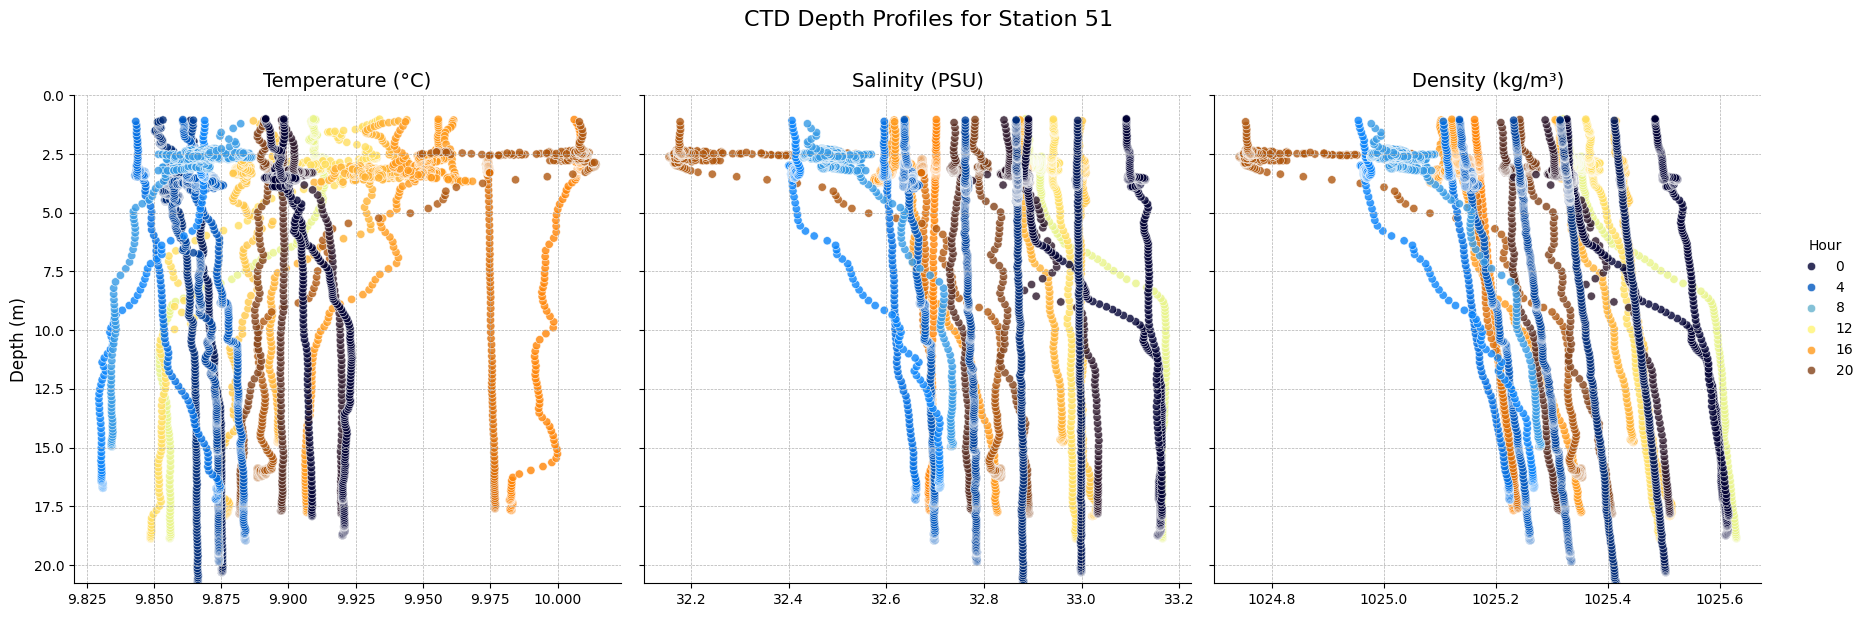

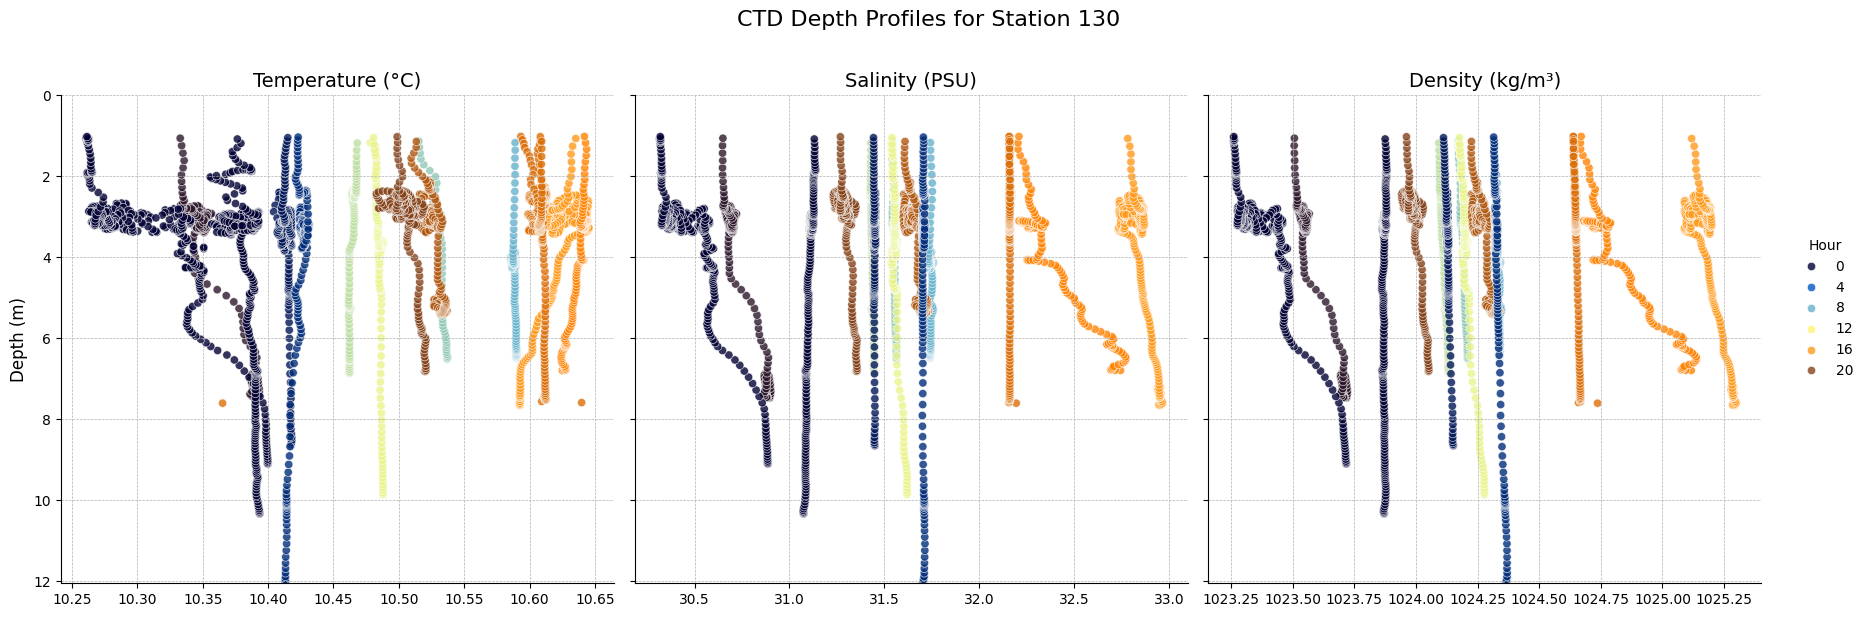

In [ ]:
# Define parameters to plot
parameters = {
    'TEMP': 'Temperature (°C)',
    'PSAL': 'Salinity (PSU)',
    'density': 'Density (kg/m³)'
}

# Create depth profiles using FacetGrid
for station in ['51', '130']:
    # Filter the CTD data for the current station
    station_depth = ctd_depth[ctd_depth['station'] == station]
    
    # Only consider the upcast data
    station_depth = station_depth[station_depth['status_2'] == 'upcast']

    # Melt the data to a long format for FacetGrid
    melted_depth = station_depth.melt(
        id_vars=['DEPTH', 'hour'],
        value_vars=parameters.keys(),
        var_name='Parameter',
        value_name='Value'
    )

    # Map parameter names to labels
    melted_depth['Parameter'] = melted_depth['Parameter'].map(parameters)

    # Determine the maximum depth in the dataset
    max_depth = station_depth['DEPTH'].max()

    # Create the FacetGrid
    g = sns.FacetGrid(
        melted_depth,
        col='Parameter',
        sharey=True,
        sharex=False,
        height=6,
        aspect=1
    )

    # Plot scatterplots on the FacetGrid
    g.map_dataframe(
        sns.scatterplot,
        x='Value',
        y='DEPTH',
        hue='hour',
        palette="diel_cyclic",
        alpha=0.8
    )

    # Apply y-axis settings explicitly for each subplot
    for ax in g.axes.flat:
        ax.set_ylim(0, max_depth)  # Set 0 as the surface level and max depth as the bottom
        ax.set_ylim(ax.get_ylim()[::-1])  # Reverse the y-axis limits (invert depth)
        ax.grid(True, linestyle='--', linewidth=0.5)

    # Adjust titles and labels
    g.set_titles(col_template="{col_name}", size=14)
    g.set_axis_labels('', 'Depth (m)', size=12)
    g.add_legend(title="Hour", title_fontsize=12, fontsize=10)

    # Set the title for the entire grid
    g.fig.suptitle(f'CTD Depth Profiles for Station {station}', fontsize=16, y=1.02)

    # Adjust layout and save
    g.tight_layout()
    g.savefig(f'../figures/environmental/profiles_B_station_{station}.svg', format='svg', dpi=600)
    g.savefig(f'../figures/environmental/profiles_B_station_{station}.png', format='png', dpi=600)

    # Show the plot
    plt.show()

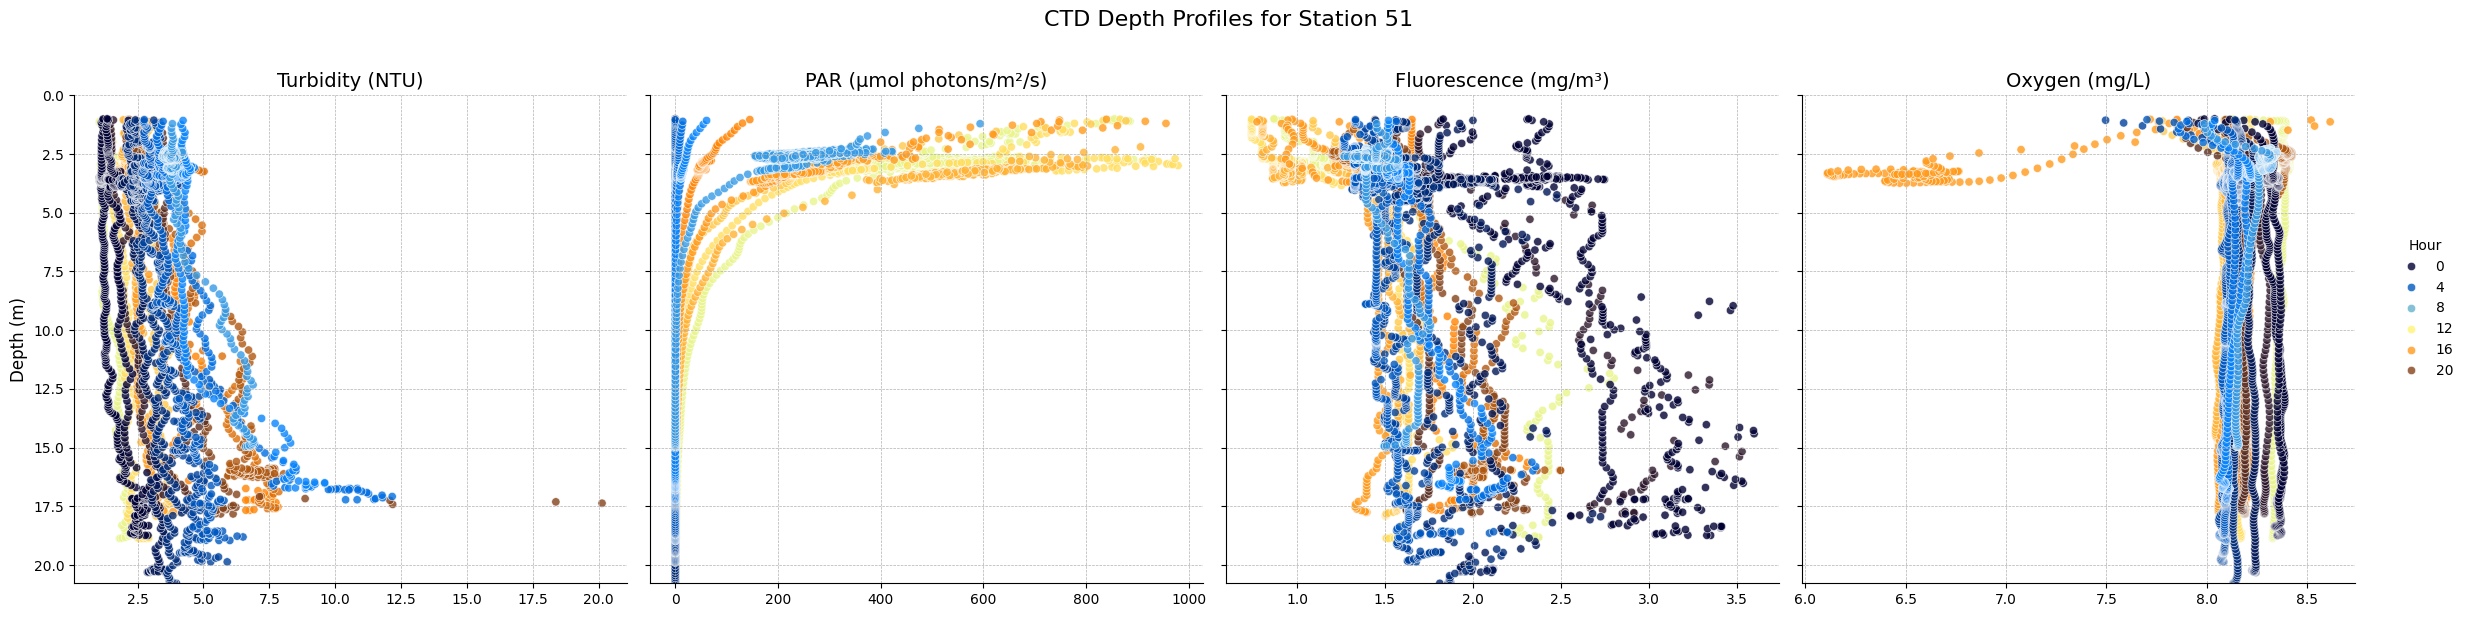

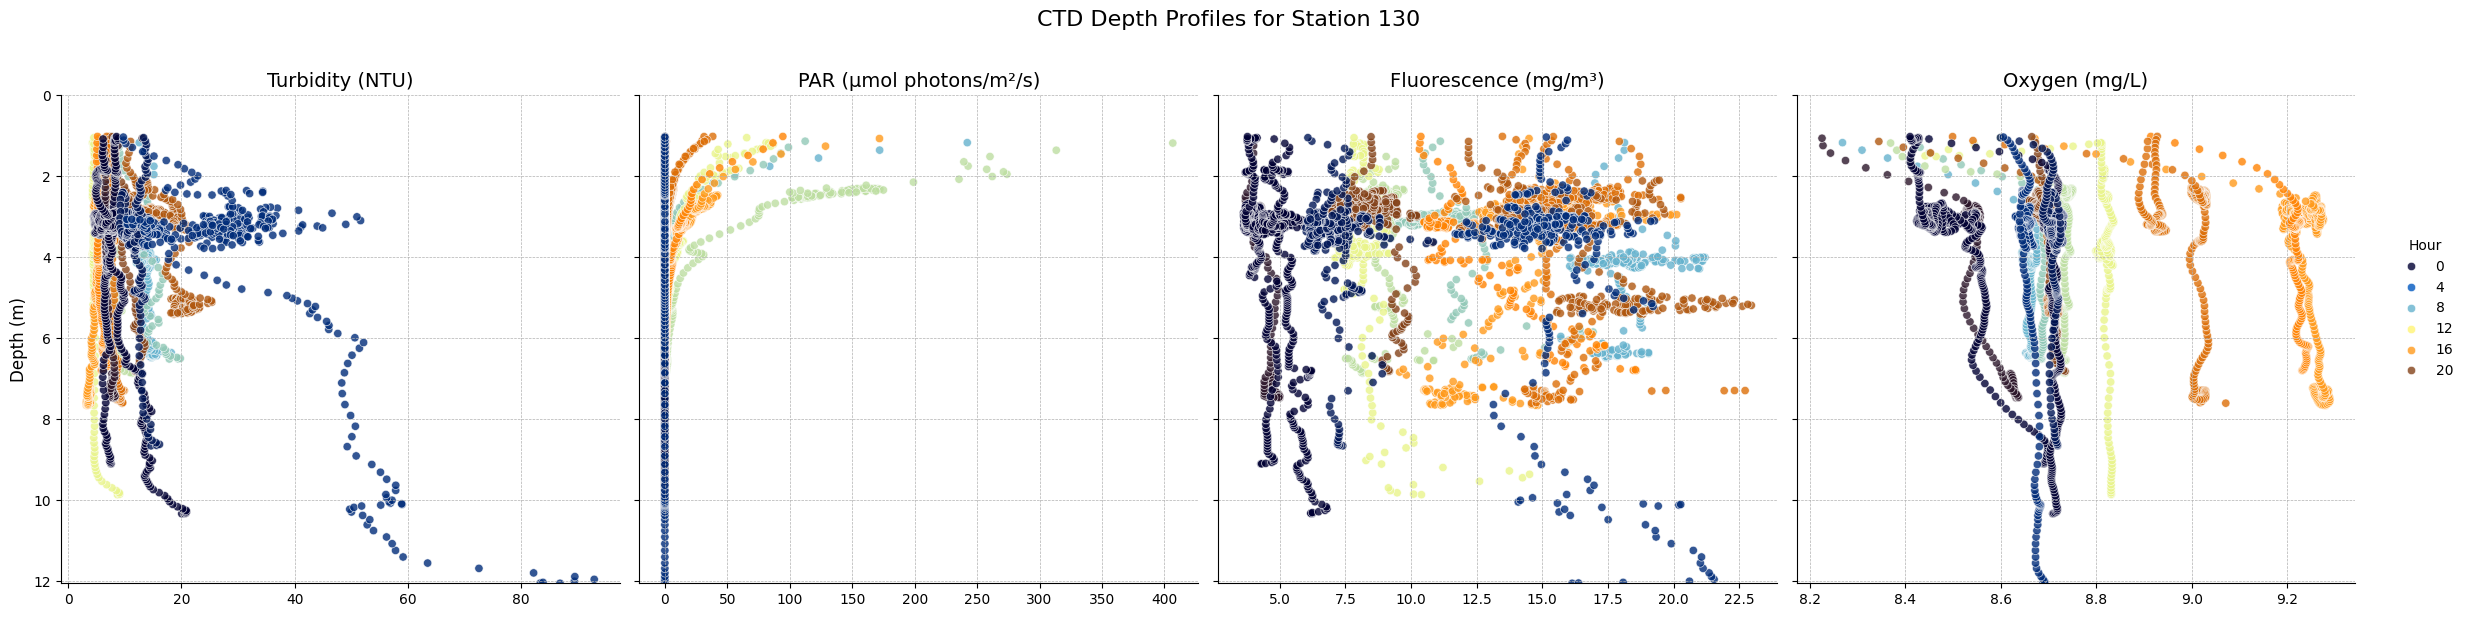

In [ ]:
# Define parameters to plot
parameters = {
    'obs3+': 'Turbidity (NTU)',
    'par': 'PAR (µmol photons/m²/s)',
    'flECO-AFL': 'Fluorescence (mg/m³)',
    'sbeox0Mg/L': 'Oxygen (mg/L)'
}

# Create depth profiles using FacetGrid
for station in ['51', '130']:
    # Filter the CTD data for the current station
    station_depth = ctd_depth[ctd_depth['station'] == station]

    # Only consider the upcast data
    station_depth = station_depth[station_depth['status_2'] == 'upcast']
    
    # Remove oxygen outliers
    station_depth = station_depth[station_depth['sbeox0Mg/L'] > 0]
    
    # Melt the data to a long format for FacetGrid
    melted_depth = station_depth.melt(
        id_vars=['DEPTH', 'hour'],
        value_vars=parameters.keys(),
        var_name='Parameter',
        value_name='Value'
    )

    # Map parameter names to labels
    melted_depth['Parameter'] = melted_depth['Parameter'].map(parameters)

    # Determine the maximum depth in the dataset
    max_depth = station_depth['DEPTH'].max()

    # Create the FacetGrid
    g = sns.FacetGrid(
        melted_depth,
        col='Parameter',
        sharey=True,
        sharex=False,
        height=6,
        aspect=1
    )

    # Plot scatterplots on the FacetGrid
    g.map_dataframe(
        sns.scatterplot,
        x='Value',
        y='DEPTH',
        hue='hour',
        palette="diel_cyclic",
        alpha=0.8
    )

    # Apply y-axis settings explicitly for each subplot
    for ax in g.axes.flat:
        ax.set_ylim(0, max_depth)  # Set 0 as the surface level and max depth as the bottom
        ax.set_ylim(ax.get_ylim()[::-1])  # Reverse the y-axis limits (invert depth)
        ax.grid(True, linestyle='--', linewidth=0.5)

    # Adjust titles and labels
    g.set_titles(col_template="{col_name}", size=14)
    g.set_axis_labels('', 'Depth (m)', size=12)
    g.add_legend(title="Hour", title_fontsize=12, fontsize=10)

    # Set the title for the entire grid
    g.fig.suptitle(f'CTD Depth Profiles for Station {station}', fontsize=16, y=1.02)

    # Adjust layout and save
    g.tight_layout()
    g.savefig(f'../figures/environmental/depth_profiles_2B_station_{station}.svg', format='svg', dpi=600)
    g.savefig(f'../figures/environmental/depth_profiles_2B_station_{station}.png', format='png', dpi=600)

    # Show the plot
    plt.show()

Now, let's calculate average PAR for the surface layer (0-2m) and visualize that value over time, as the PAR value from the environmental data does not seem trustworthy.

Unique hours for station 51: <DatetimeArray>
['2023-04-18 11:00:00', '2023-04-18 13:00:00', '2023-04-18 14:00:00',
 '2023-04-18 15:00:00', '2023-04-18 16:00:00', '2023-04-18 17:00:00',
 '2023-04-18 18:00:00', '2023-04-18 19:00:00', '2023-04-18 20:00:00',
 '2023-04-18 21:00:00', '2023-04-18 22:00:00', '2023-04-18 23:00:00',
 '2023-04-19 00:00:00', '2023-04-19 01:00:00', '2023-04-19 02:00:00',
 '2023-04-19 03:00:00', '2023-04-19 04:00:00', '2023-04-19 05:00:00',
 '2023-04-19 06:00:00', '2023-04-19 07:00:00']
Length: 20, dtype: datetime64[ns]


/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_61605/3825811770.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  station_depth['date_hour'] = station_depth['date'].dt.floor('H')


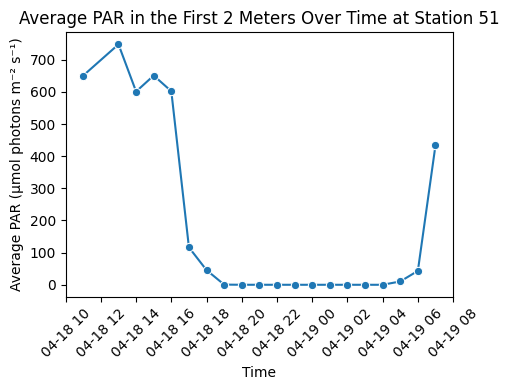

/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_61605/3825811770.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  station_depth['date_hour'] = station_depth['date'].dt.floor('H')


Unique hours for station 130: <DatetimeArray>
['2023-04-20 08:00:00', '2023-04-20 09:00:00', '2023-04-20 10:00:00',
 '2023-04-20 11:00:00', '2023-04-20 16:00:00', '2023-04-20 17:00:00',
 '2023-04-20 18:00:00', '2023-04-20 19:00:00', '2023-04-20 20:00:00',
 '2023-04-20 22:00:00', '2023-04-20 23:00:00', '2023-04-21 00:00:00',
 '2023-04-21 01:00:00', '2023-04-21 02:00:00']
Length: 14, dtype: datetime64[ns]


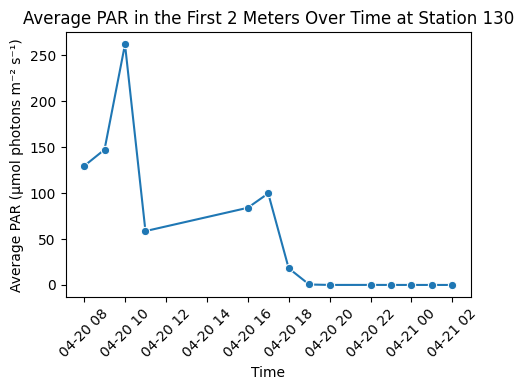

In [ ]:
for station in ['51', '130']:
    # Filter the CTD data for the current station
    station_depth = ctd_depth[ctd_depth['station'] == station]

    # Filter for depths <= 2 meters
    station_depth = station_depth[station_depth['DEPTH'] <= 2]

    # Group by hour
    station_depth['date_hour'] = station_depth['date'].dt.floor('H')
    # Print the unique hours for this station
    print(f"Unique hours for station {station}: {station_depth['date_hour'].unique()}")
    # Calculate the average PAR for each hour
    station_depth_grouped = station_depth.groupby('date_hour').agg({'par': 'mean'}).reset_index()

    # Plot average PAR over time
    plt.figure(figsize=(5, 4))
    sns.lineplot(data=station_depth_grouped, x='date_hour', y='par', marker='o')
    plt.title(f'Average PAR in the First 2 Meters Over Time at Station {station}')
    plt.xlabel('Time')
    plt.ylabel('Average PAR (µmol photons m⁻² s⁻¹)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_57961/1690738111.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  station_depth['date_hour'] = station_depth['date'].dt.floor('H')


Unique hours for station 51: <DatetimeArray>
['2023-04-18 11:00:00', '2023-04-18 13:00:00', '2023-04-18 14:00:00',
 '2023-04-18 15:00:00', '2023-04-18 16:00:00', '2023-04-18 17:00:00',
 '2023-04-18 18:00:00', '2023-04-18 19:00:00', '2023-04-18 20:00:00',
 '2023-04-18 21:00:00', '2023-04-18 22:00:00', '2023-04-18 23:00:00',
 '2023-04-19 00:00:00', '2023-04-19 01:00:00', '2023-04-19 02:00:00',
 '2023-04-19 03:00:00', '2023-04-19 04:00:00', '2023-04-19 05:00:00',
 '2023-04-19 06:00:00', '2023-04-19 07:00:00']
Length: 20, dtype: datetime64[ns]


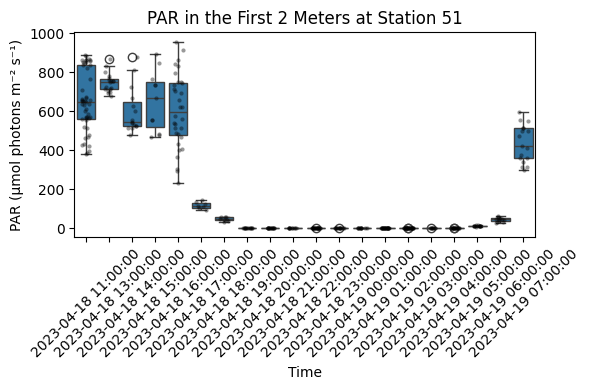

Unique hours for station 130: <DatetimeArray>
['2023-04-20 08:00:00', '2023-04-20 09:00:00', '2023-04-20 10:00:00',
 '2023-04-20 11:00:00', '2023-04-20 16:00:00', '2023-04-20 17:00:00',
 '2023-04-20 18:00:00', '2023-04-20 19:00:00', '2023-04-20 20:00:00',
 '2023-04-20 22:00:00', '2023-04-20 23:00:00', '2023-04-21 00:00:00',
 '2023-04-21 01:00:00', '2023-04-21 02:00:00']
Length: 14, dtype: datetime64[ns]


/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_57961/1690738111.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  station_depth['date_hour'] = station_depth['date'].dt.floor('H')


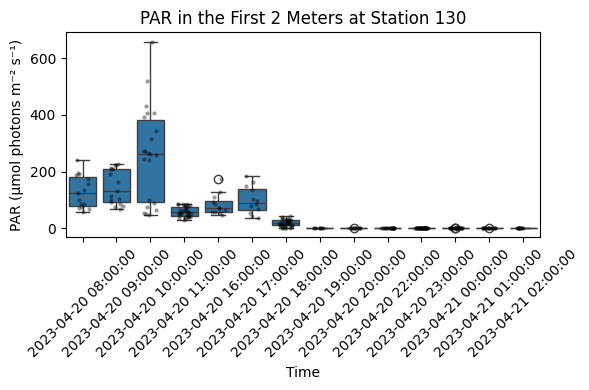

In [ ]:
for station in ['51', '130']:
    # Filter the CTD data for the current station
    station_depth = ctd_depth[ctd_depth['station'] == station]

    # Filter for depths <= 2 meters
    station_depth = station_depth[station_depth['DEPTH'] <= 2]

    # Group by hour
    station_depth['date_hour'] = station_depth['date'].dt.floor('H')

    # Print the unique hours for this station
    print(f"Unique hours for station {station}: {station_depth['date_hour'].unique()}")

    # Plot boxplot of all PAR values per hour
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=station_depth, x='date_hour', y='par')
    sns.stripplot(data=station_depth, x='date_hour', y='par', color='black', alpha=0.4, jitter=0.2, size=3)

    plt.title(f'PAR in the First 2 Meters at Station {station}')
    plt.xlabel('Time')
    plt.ylabel('PAR (µmol photons m⁻² s⁻¹)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Unique hours for station 51: <DatetimeArray>
['2023-04-18 11:00:00', '2023-04-18 13:00:00', '2023-04-18 14:00:00',
 '2023-04-18 15:00:00', '2023-04-18 16:00:00', '2023-04-18 17:00:00',
 '2023-04-18 18:00:00', '2023-04-18 19:00:00', '2023-04-18 20:00:00',
 '2023-04-18 21:00:00', '2023-04-18 22:00:00', '2023-04-18 23:00:00',
 '2023-04-19 00:00:00', '2023-04-19 01:00:00', '2023-04-19 02:00:00',
 '2023-04-19 03:00:00', '2023-04-19 04:00:00', '2023-04-19 05:00:00',
 '2023-04-19 06:00:00', '2023-04-19 07:00:00']
Length: 20, dtype: datetime64[ns]


/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_57961/4000455937.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  station_depth['date_hour'] = station_depth['date'].dt.floor('H')


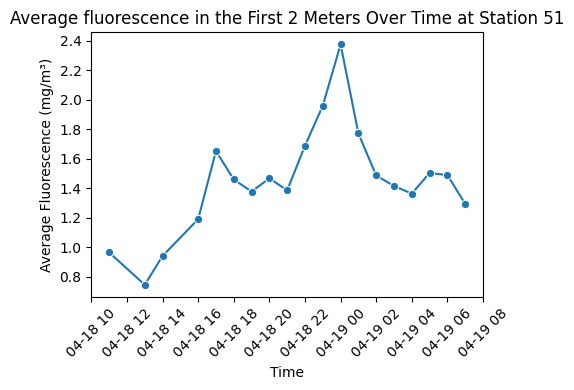

/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_57961/4000455937.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  station_depth['date_hour'] = station_depth['date'].dt.floor('H')


Unique hours for station 130: <DatetimeArray>
['2023-04-20 08:00:00', '2023-04-20 09:00:00', '2023-04-20 10:00:00',
 '2023-04-20 11:00:00', '2023-04-20 16:00:00', '2023-04-20 17:00:00',
 '2023-04-20 18:00:00', '2023-04-20 19:00:00', '2023-04-20 20:00:00',
 '2023-04-20 22:00:00', '2023-04-20 23:00:00', '2023-04-21 00:00:00',
 '2023-04-21 01:00:00', '2023-04-21 02:00:00']
Length: 14, dtype: datetime64[ns]


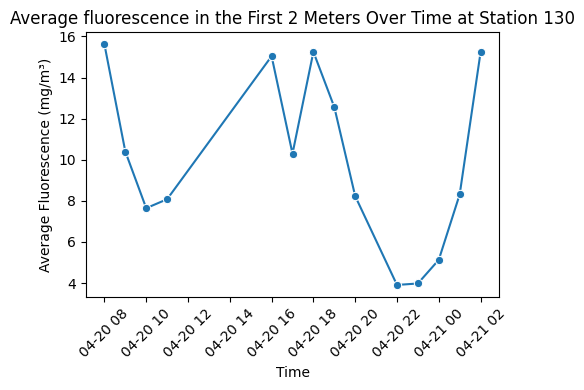

In [ ]:
for station in ['51', '130']:
    # Filter the CTD data for the current station
    station_depth = ctd_depth[ctd_depth['station'] == station]

    # Filter for depths <= 2 meters
    station_depth = station_depth[station_depth['DEPTH'] <= 2]

    # Group by hour
    station_depth['date_hour'] = station_depth['date'].dt.floor('H')
    # Print the unique hours for this station
    print(f"Unique hours for station {station}: {station_depth['date_hour'].unique()}")
    # Calculate the average PAR for each hour
    station_depth_grouped = station_depth.groupby('date_hour').agg({'flECO-AFL': 'mean'}).reset_index()
    
    # For station 51, remove outlier at 14:00
    if station == '51':
        station_depth_grouped = station_depth_grouped[station_depth_grouped['date_hour'] != '2023-04-18 15:00:00']

    # Plot average PAR over time
    plt.figure(figsize=(5, 4))
    sns.lineplot(data=station_depth_grouped, x='date_hour', y='flECO-AFL', marker='o')
    plt.title(f'Average fluorescence in the First 2 Meters Over Time at Station {station}')
    plt.xlabel('Time')
    plt.ylabel('Average Fluorescence (mg/m³)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_57961/803377777.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  station_depth['date_hour'] = station_depth['date'].dt.floor('H')


Unique hours for station 51: <DatetimeArray>
['2023-04-18 11:00:00', '2023-04-18 13:00:00', '2023-04-18 14:00:00',
 '2023-04-18 15:00:00', '2023-04-18 16:00:00', '2023-04-18 17:00:00',
 '2023-04-18 18:00:00', '2023-04-18 19:00:00', '2023-04-18 20:00:00',
 '2023-04-18 21:00:00', '2023-04-18 22:00:00', '2023-04-18 23:00:00',
 '2023-04-19 00:00:00', '2023-04-19 01:00:00', '2023-04-19 02:00:00',
 '2023-04-19 03:00:00', '2023-04-19 04:00:00', '2023-04-19 05:00:00',
 '2023-04-19 06:00:00', '2023-04-19 07:00:00']
Length: 20, dtype: datetime64[ns]


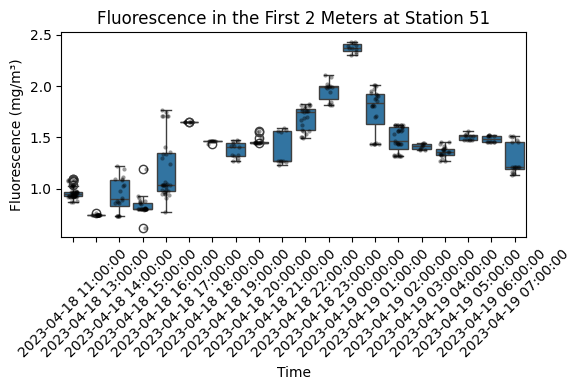

Unique hours for station 130: <DatetimeArray>
['2023-04-20 08:00:00', '2023-04-20 09:00:00', '2023-04-20 10:00:00',
 '2023-04-20 11:00:00', '2023-04-20 16:00:00', '2023-04-20 17:00:00',
 '2023-04-20 18:00:00', '2023-04-20 19:00:00', '2023-04-20 20:00:00',
 '2023-04-20 22:00:00', '2023-04-20 23:00:00', '2023-04-21 00:00:00',
 '2023-04-21 01:00:00', '2023-04-21 02:00:00']
Length: 14, dtype: datetime64[ns]


/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_57961/803377777.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  station_depth['date_hour'] = station_depth['date'].dt.floor('H')


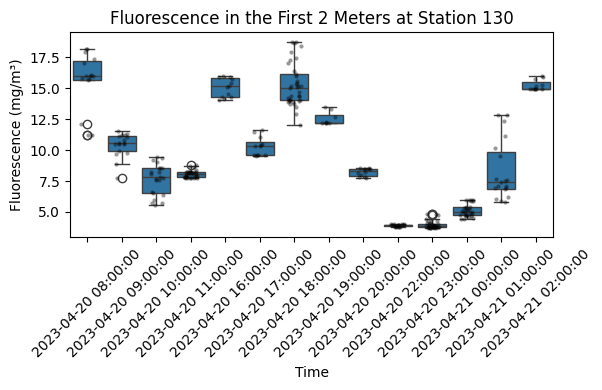

In [ ]:
for station in ['51', '130']:
    # Filter the CTD data for the current station
    station_depth = ctd_depth[ctd_depth['station'] == station]

    # Filter for depths <= 2 meters
    station_depth = station_depth[station_depth['DEPTH'] <= 2]

    # Group by hour
    station_depth['date_hour'] = station_depth['date'].dt.floor('H')

    # Print the unique hours for this station
    print(f"Unique hours for station {station}: {station_depth['date_hour'].unique()}")

    # For station 51, remove values above 40 and below 0 as these are outliers
    if station == '51':
        station_depth = station_depth[(station_depth['flECO-AFL'] < 40) & (station_depth['flECO-AFL'] > 0)]

    # Plot boxplot of all fluorescence values per hour
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=station_depth, x='date_hour', y='flECO-AFL')
    sns.stripplot(data=station_depth, x='date_hour', y='flECO-AFL', color='black', alpha=0.4, jitter=0.2, size=3)

    plt.title(f'Fluorescence in the First 2 Meters at Station {station}')
    plt.xlabel('Time')
    plt.ylabel('Fluorescence (mg/m³)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_6494/1917061695.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


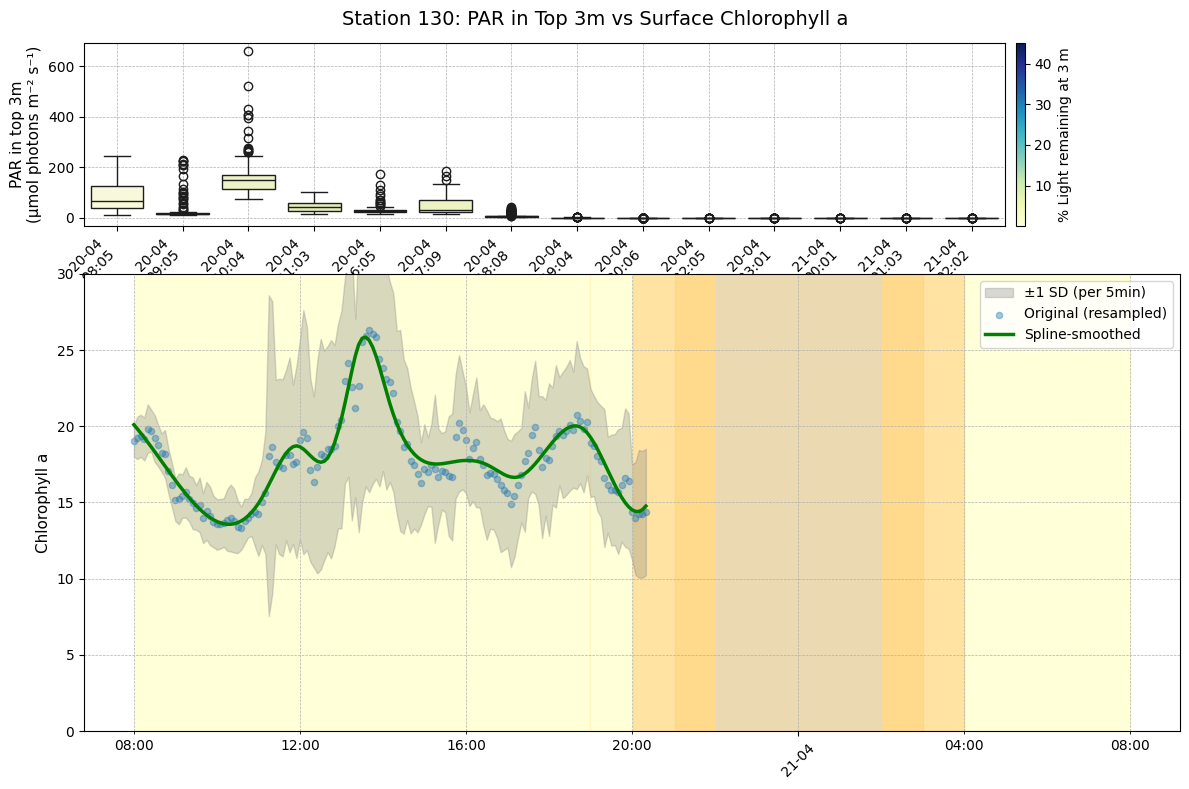

In [ ]:
# Let's create a boxplot showing PAR with colour coding for light remaining at 3m depth:
# Calculate light attenuation (Kd) and % PAR at 3m per CTD cast
kd_summary = []

for cast in ctd_depth['STATION'].unique():
    df_cast = ctd_depth[
        (ctd_depth['STATION'] == cast) &
        (ctd_depth['DEPTH'] >= 0.5) & (ctd_depth['DEPTH'] <= 5.0) &
        (ctd_depth['par'] > 0)
    ].copy()
    
    # Sample time should be in datetime format
    df_cast['sampletime'] = pd.to_datetime(df_cast['sampletime'])

    if len(df_cast) >= 3:
        df_cast['ln_PAR'] = np.log(df_cast['par'])
        slope, intercept = np.polyfit(df_cast['DEPTH'], df_cast['ln_PAR'], 1)
        kd = -slope
        surface_PAR = np.exp(intercept)
        par_at_3m = surface_PAR * np.exp(-kd * 3)
        light_percent = 100 * par_at_3m / surface_PAR

        kd_summary.append({
            'station': df_cast['station'].iloc[0],
            'STATION': cast,
            'datetime': df_cast['sampletime'].median(),
            'Kd': kd,
            'PAR_0': surface_PAR,
            'PAR_3m_est': par_at_3m,
            'light_at_3m_percent': light_percent
        })

par_kd_casts = pd.DataFrame(kd_summary)

In [ ]:
def plot_par_boxplots_aligned(ctd_depth, par_kd_casts, station_name, start_time, end_time):

    # Convert cm to inches for figure size
    fig_width = 5  # 9 cm
    fig_height = fig_width * 0.4
    font_main = 10
    font_tick = 8

    # Filter for station and depth
    shallow_ctd = ctd_depth[
        (ctd_depth['station'] == station_name) &
        (ctd_depth['DEPTH'] >= 1) &
        (ctd_depth['DEPTH'] <= 3)
    ].copy()

    # Merge light percent
    shallow_ctd = shallow_ctd.merge(
        par_kd_casts[['STATION', 'light_at_3m_percent', 'datetime']],
        on='STATION', how='left'
    )

    shallow_ctd['time_bin'] = shallow_ctd['datetime'].dt.floor('H')
    full_range = pd.date_range(start=start_time, end=end_time, freq='1H')

    cast_medians = shallow_ctd.groupby('time_bin')['light_at_3m_percent'].first()
    norm = mcolors.Normalize(vmin=cast_medians.min(), vmax=cast_medians.max())
    cmap = cm.get_cmap('YlGnBu')
    box_colors = {t: cmap(norm(v)) for t, v in cast_medians.items()}

    # Plot
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    sns.boxplot(
        data=shallow_ctd,
        x='time_bin',
        y='par',
        order=full_range,
        palette=[box_colors.get(t, "#dddddd") for t in full_range],
        showfliers=False,
        ax=ax
    )

    sns.stripplot(
        data=shallow_ctd,
        x='time_bin',
        y='par',
        order=full_range,
        color='black',
        size=1.5,
        alpha=0.4,
        ax=ax
    )
    
    # Format x-tick labels
    visible_xticks = [i for i, t in enumerate(full_range) if i % 2 == 0]
    
    xtick_labels = []
    for i, t in enumerate(full_range):
        if i in visible_xticks:
            if t == full_range[0] or t.hour == 0 or t == full_range[-1]:
                label = t.strftime('%d-%m\n%H:%M')
            else:
                label = t.strftime('\n%H:%M')
        else:
            label = ''  # skip this label
        xtick_labels.append(label)
    
    ax.set_xticks(range(len(full_range)))
    ax.set_xticklabels(xtick_labels, rotation=0, ha='center', fontsize=font_tick)

    ax.set_xlim(-0.5, len(full_range) - 0.5)
    ax.set_ylabel(None)
    ax.set_ylim(0, 1000)
    ax.set_xlabel(None)
    ax.tick_params(axis='y', labelsize=font_tick)
    ax.grid(True, linestyle='--', linewidth=0.4)

    sm = cm.ScalarMappable(cmap='YlGnBu', norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation="vertical", pad=0.01)
    cbar.set_label(None)
    cbar.ax.tick_params(labelsize=font_tick)

    plt.tight_layout()
    # Save the figure
    plt.savefig(f'../figures/environmental/boxplot_PAR_{station_name}.svg', format='svg', dpi=1200)
    plt.show();

/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_6494/858093093.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  shallow_ctd['time_bin'] = shallow_ctd['datetime'].dt.floor('H')
/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_6494/858093093.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=start_time, end=end_time, freq='1H')
/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_6494/858093093.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('YlGnBu')
/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_6494/858093093.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed i

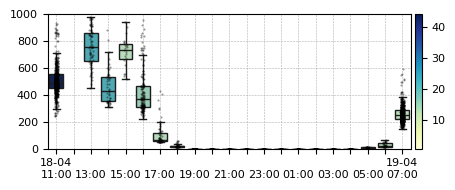

/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_6494/858093093.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  shallow_ctd['time_bin'] = shallow_ctd['datetime'].dt.floor('H')
/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_6494/858093093.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=start_time, end=end_time, freq='1H')
/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_6494/858093093.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('YlGnBu')
/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_6494/858093093.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed i

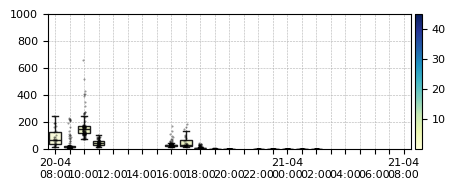

In [ ]:
plot_par_boxplots_aligned(ctd_depth, par_kd_casts, station_name='51',
                          start_time='2023-04-18 11:00', end_time='2023-04-19 07:00')

plot_par_boxplots_aligned(ctd_depth, par_kd_casts, station_name='130',
                          start_time='2023-04-20 08:00', end_time='2023-04-21 08:00')

In [ ]:
par_kd_casts.head()

NameError: name 'par_kd_casts' is not defined

In [ ]:
# Save the PAR values at 3m depth for every sample
par_kd_casts.to_csv('../data/par_kd_casts.csv', index=False)


### T/S Diagrams


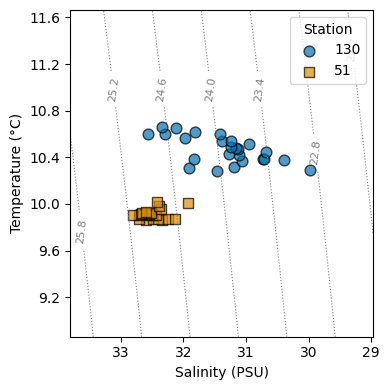

In [70]:
import gsw
from matplotlib.ticker import MaxNLocator

def ts_plot(dataframe, salinity_col='CTD > Salinity', temp_col='CTD > Temperature', station_col='Code'):
    """
    Creates a classical T-S (Temperature-Salinity) diagram with density contours.
    Identifies different water masses based on density (sigma-theta, σ₀).

    Parameters:
    dataframe (DataFrame): The DataFrame containing temperature, salinity, and station data.
    salinity_col (str): Column name for salinity.
    temp_col (str): Column name for temperature.
    station_col (str): Column name for station ID.
    """

    # Ensure numeric types and drop NaNs
    dataframe = dataframe[[salinity_col, temp_col, station_col]].dropna().copy()
    dataframe[salinity_col] = pd.to_numeric(dataframe[salinity_col], errors='coerce')
    dataframe[temp_col] = pd.to_numeric(dataframe[temp_col], errors='coerce')

    # Sort data for smooth contours
    dataframe = dataframe.sort_values(temp_col, ascending=True)

    # Define grid for density contours
    min_temp, max_temp = dataframe[temp_col].min(), dataframe[temp_col].max()
    min_sal, max_sal = dataframe[salinity_col].min(), dataframe[salinity_col].max()

    temp_grid = np.linspace(min_temp - 1, max_temp + 1, 100)
    sal_grid = np.linspace(min_sal - 1, max_sal + 1, 100)
    T_grid, S_grid = np.meshgrid(temp_grid, sal_grid)

    # Calculate sigma-theta (density anomaly)
    sigma_theta = gsw.sigma0(S_grid, T_grid)
    sigma_levels = np.linspace(sigma_theta.min(), sigma_theta.max(), 15)  # 15 contour levels

    # Define **consistent station markers**  
    station_markers = {'130': 'o', '51': 's'}  
    station_colors = sns.color_palette("colorblind", n_colors=len(station_markers))

    # Create T-S plot
    fig, ax = plt.subplots(figsize=(4, 4))

    # Plot density contours
    cs = ax.contour(S_grid, T_grid, sigma_theta, colors='gray', linewidths=0.8, linestyles='dotted')
    ax.clabel(cs, fmt='%.1f', fontsize=8, inline=True)

    # Plot station data with **consistent markers**
    for (station, marker), color in zip(station_markers.items(), station_colors):
        subset = dataframe[dataframe[station_col] == station]
        ax.scatter(subset[salinity_col], subset[temp_col], label=station, 
                   marker=marker, color=color, edgecolors='black', s=60, alpha=0.7)

    # Customize plot appearance
    ax.set_xlabel("Salinity (PSU)", fontsize=10)
    ax.set_ylabel("Temperature (°C)", fontsize=10)
    ax.set_title(None)

    # Reverse x-axis for standard oceanographic T-S presentation
    ax.invert_xaxis()

    # Set major tick intervals
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=8))
    
    # Add legend
    ax.legend(title="Station", fontsize=10, loc='upper right')

    # Save high-resolution figure
    plt.tight_layout()
    plt.savefig("../figures/environmental/ts_diagram.svg", dpi=800, bbox_inches='tight')

    plt.show()


ts_plot(ctd_data, salinity_col='Salinity', temp_col='Temperature', station_col='StationPrefix')

### Underway data
Here, we'll visualize chlorophyll-a data from the underway system. The underway data has the following columns:
- **Time**: .Time in UTC, beginning of sample time period.
- **Latitude**: Center latitude in decimal degrees, WGS84.
- **Longitude**: Center longitude in decimal degrees, WGS84.
- **Temperature**: Temperature of the water body, expressed in degrees Celcius.
- **Salinity**: Salinity of the water body, expressed in PSU.
- **Conductivity**: Conductivity of the water body, expressed in ms/cm.
- **Depth**: Depth between the echosounder and the bottom, measured by echosounder 200 kHz, expressed in m.
- **ChlorophylA**: Concentration of Chlorophyll A, based on fluoresence, measured by SBE21, expressed in µg/L.
- **SpeedMadeGood**: Average speed of the research vessel between a time interval of 5 seconds, expressed in knots.
- **Speedlog**: Speed of water, relative to the hull of the RV Simon Stevin, expressed in knots.
- **TrueWindDir**: Direction of the wind in deg.
- **TrueWindSpeed**: Speed of the wind in m/s.
- **CourseMadeGood**: Average heading of the research vessel between a time interval of 5 seconds, expressed in degrees.
- **Gyro**: Exact heading of the research vessel, measured by Gyro, expressed in degrees.
- **AirTemperature**: Temperature of air, expressed in degrees Celcius.
- **AirPressure**: Atmospheric pressure of the air, expressed in mBar.
- **AirHumidity**: Relative humidity of the air, expressed in %.

The data was downloaded from https://rshiny.lifewatch.be/underway-data/, thereby specifying the date range of the campaign.

In [9]:
underway = pd.read_table('../data/raw/LWdownload_2025-04-02.tab')
underway.head()

Time   Latitude  Longitude  Temperature  Salinity  \
0  2023-04-17 08:30:18  51.256228   2.871510      10.3791    33.368   
1  2023-04-17 08:31:00  51.256727   2.868621      10.3616    33.414   
2  2023-04-17 08:32:06  51.257522   2.864085      10.3440    33.438   
3  2023-04-17 08:33:00  51.258177   2.860383      10.3348    33.462   
4  2023-04-17 08:34:00  51.258903   2.856283      10.3307    32.693   

   Conductivity  Depth  ChlorophylA  SpeedMadeGood  Speedlog  TrueWindDir  \
0         3.728  13.30         4.77            9.9     11.41         41.6   
1         3.729  13.57         4.77            9.6     11.33         43.2   
2         3.730  14.02         4.77            9.4     11.36         48.4   
3         3.730  14.52         4.77            9.5     11.39         45.8   
4         3.630  14.78         4.77            9.8     11.36         47.9   

   TrueWindSpeed  CourseMadeGood    Gyro  AirTemperature  AirPressure  \
0           7.75           286.8  283.93            8.20       1.0269   
1           7.17           285.0  282.89            8.19       1.0269   
2           8.22           286.2  283.88            8.17       1.0269   
3           8.59           286.3  284.15            8.15       1.0268   
4           7.21           285.1  283.40            8.13       1.0269   

   AirHumidity  
0         92.9  
1         93.7  
2         93.7  
3         93.8  
4         93.3

Sadly, chlorophyll a data is constant throughout the campaign, and therefore not useful for analysis. 